<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/Aging_CRV168.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and get a ticket

In [1]:
!pip install -q hist
!pip install -q mplhep==0.2.9 # Latest version requires new version of matplot lib
!pip install -q uproot
!pip install lmfit

import hist

import mplhep as hep
hep.style.set_style('ATLAS')  # or ATLAS/LHCb2

     |████████████████████████████████| 1.4 MB 9.1 MB/s 
     |████████████████████████████████| 5.4 MB 5.2 MB/s 
     |████████████████████████████████| 302 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.4 MB/s 
     |████████████████████████████████| 98 kB 7.1 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=91afc8482089ab784891ca8daeba7165bf46f5bb117c3ca312a84dc03c73062a
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import uproot
from scipy import stats
import re
import glob
import sys
import lmfit
from lmfit.models import LinearModel
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 100)
plt.rcParams.update({'figure.max_open_warning': 0})
BAD_RUNS=[42]

In [3]:
!apt-get -qq install krb5-user > /dev/null
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'
!kinit oksuzian@FNAL.GOV

--2022-09-10 08:05:00--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.03s   

2022-09-10 08:05:00 (501 KB/s) - ‘krb5.conf’ saved [17486/17486]

Password for oksuzian@FNAL.GOV: 


#Get root files with runSummary

In [10]:
!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/crvaging-004/rec.mu2e.CRV_wideband_cosmics.*.root .

In [90]:
df = pd.DataFrame()
listing = glob.glob('rec.*.root')
for root_file in listing:
  print(root_file)
  run = int(re.split('\.|_', root_file)[6])
  subrun = int(re.split('\.|_', root_file)[7])
  if run in BAD_RUNS:
    continue

  for key in uproot.open(root_file).keys():
    if 'spill' in key:
      continue
    tree = uproot.open(root_file+":"+key)
    df_ = tree.arrays(library="pd")
    df_.columns = df_.columns.str.replace(r'\[', '_')
    df_.columns = df_.columns.str.replace(r'\]', '')

    df_['run'] = int(run)
    df_['subrun'] = int(subrun)
    df = df.append(df_)

rec.mu2e.CRV_wideband_cosmics.crvaging-004.001082_000.root


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

rec.mu2e.CRV_wideband_cosmics.crvaging-003.001091_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001084_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001080_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001054_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001059_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001066_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001133_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001124_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001134_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001053_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001081_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001079_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001116_000.root


In [91]:
columns = 'PEsTemperatureCorrected|meanTemperatures|calibConstantsTemperatureCorrected|run|timestamp|febTemperaturesAvg|biasVoltagesAvg'
df=df.filter(regex=columns)

<Figure size 630x426.24 with 0 Axes>

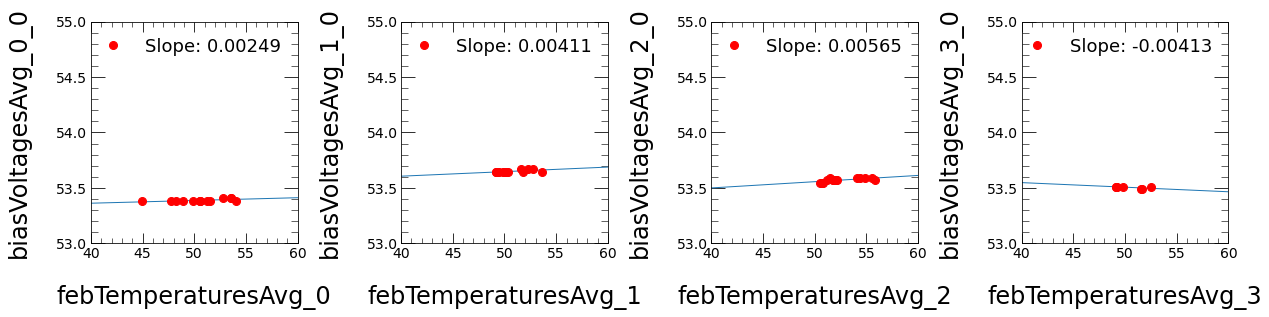

<Figure size 630x426.24 with 0 Axes>

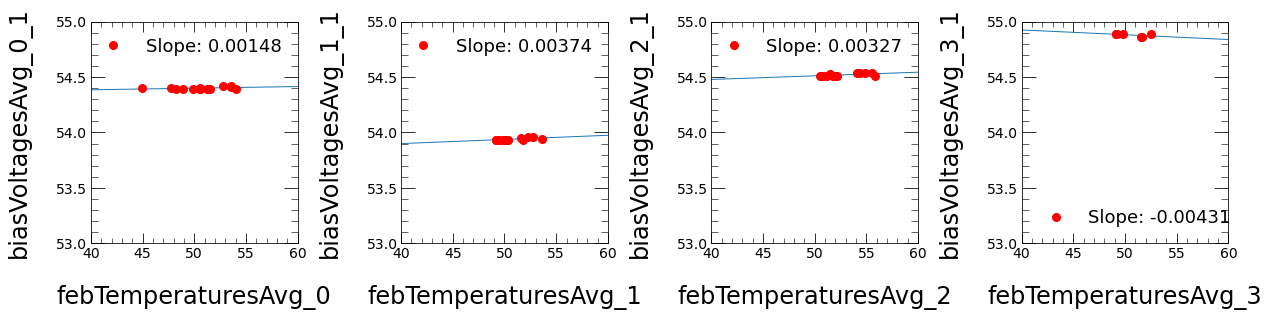

<Figure size 630x426.24 with 0 Axes>

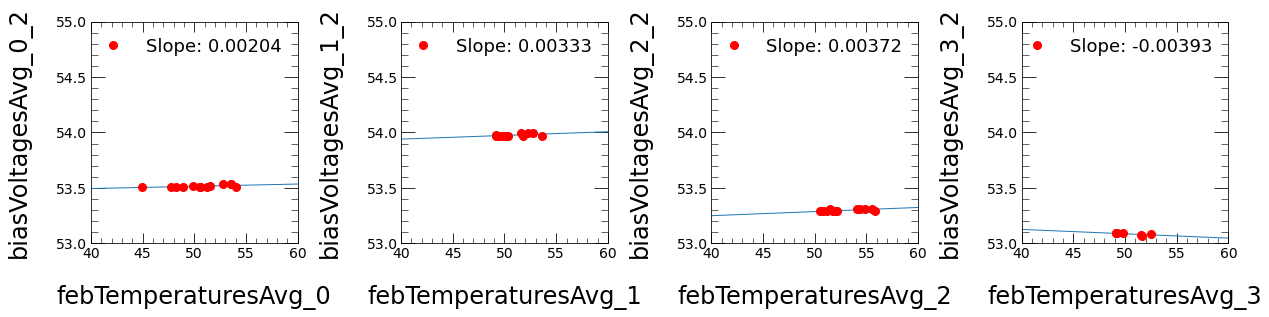

<Figure size 630x426.24 with 0 Axes>

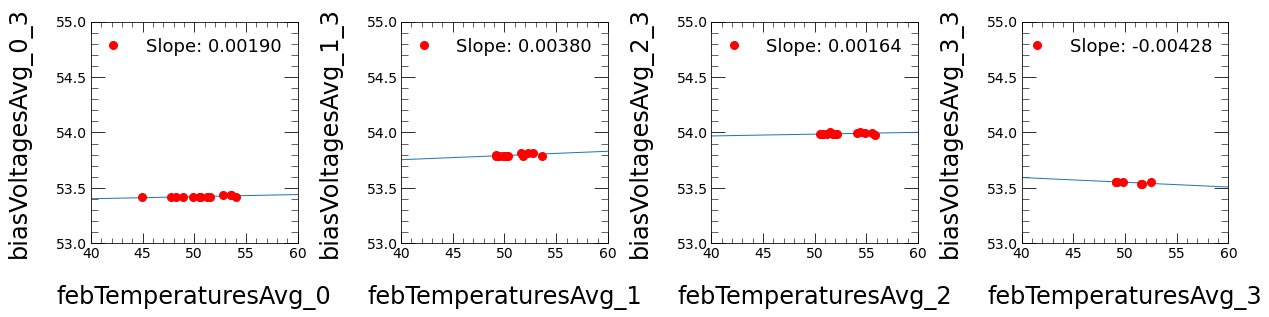

<Figure size 630x426.24 with 0 Axes>

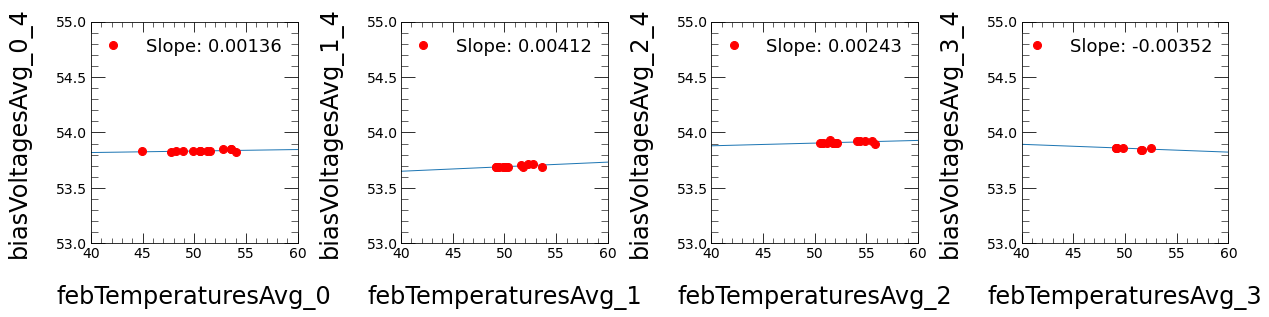

<Figure size 630x426.24 with 0 Axes>

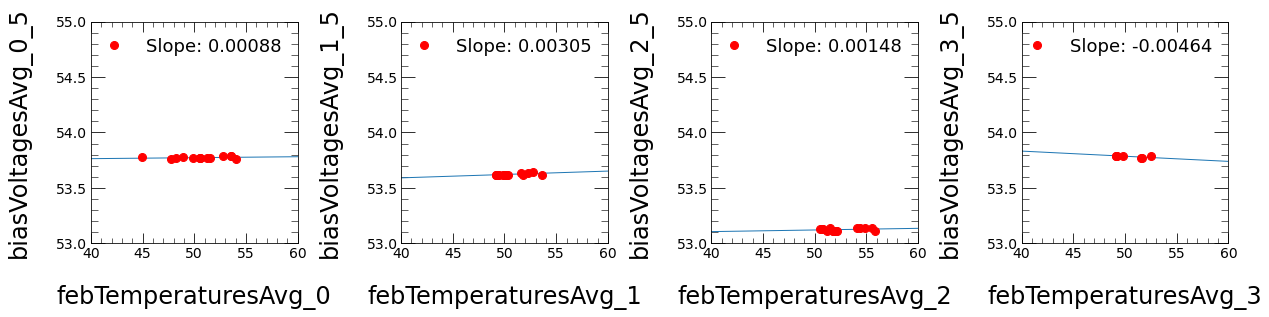

<Figure size 630x426.24 with 0 Axes>

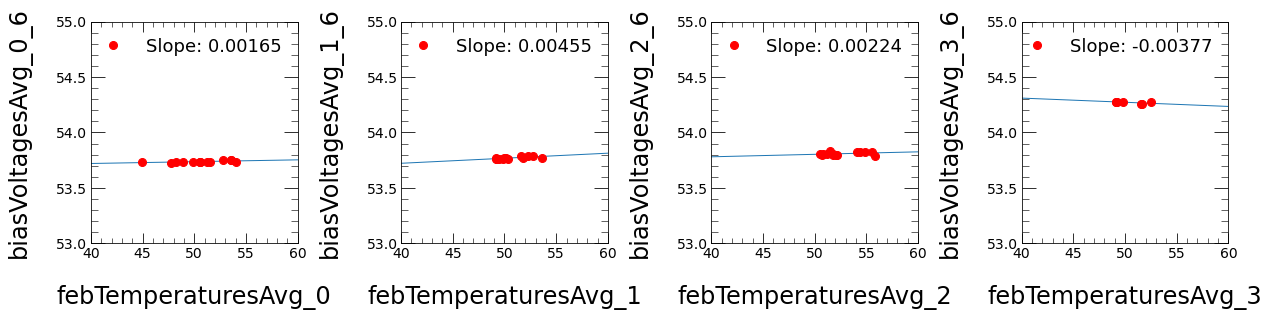

<Figure size 630x426.24 with 0 Axes>

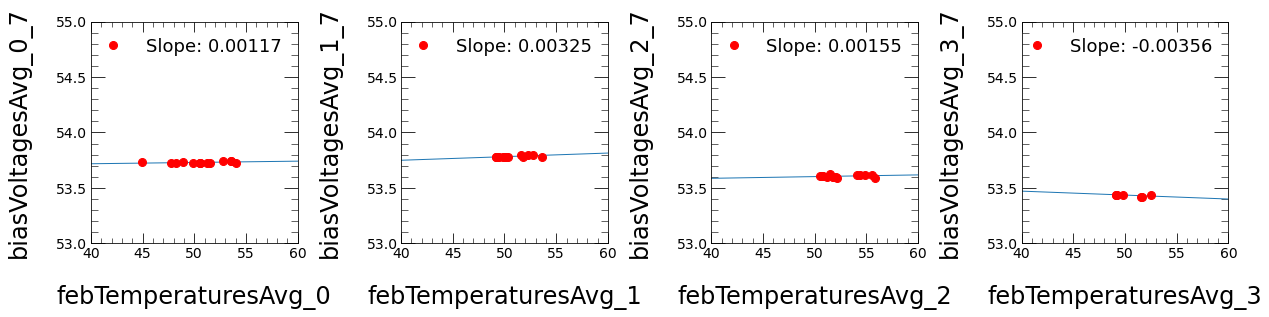

In [92]:
for i in range(0,8):

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
  plt.subplots_adjust(wspace=0.5)

  for feb in range(0, 4):
#    df_ = df.query('febTemperaturesAvg_%d > 0'%(feb))
    df_ = df
    x=df_['febTemperaturesAvg_%d'%(feb)].dropna()
    y=df_['biasVoltagesAvg_%d_%d'%(feb, i)].dropna()

    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(40, 60, 100)
    ax1[feb].plot(xline, linmodel(xline))
    ax1[feb].plot(x,y,'ro', label='Slope: %.5f'%linmodel.coeffs[0])

    ax1[feb].set_xlabel('febTemperaturesAvg_%d'%(feb))
    ax1[feb].set_ylabel('biasVoltagesAvg_%d_%d'%(feb, i))
    ax1[feb].set_xlim(40,60)
    ax1[feb].set_ylim(53,55)
    ax1[feb].legend()

In [93]:
df = df.sort_values('timestamp')
#Convert columns to proper data types
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
df['hours']=df['timestamp']/3600
df['days']=df['hours']/24
pd.options.mode.chained_assignment = None
df['years']=(df['days']-df.query('days>=0')['days'].min())/365 #Convert to years

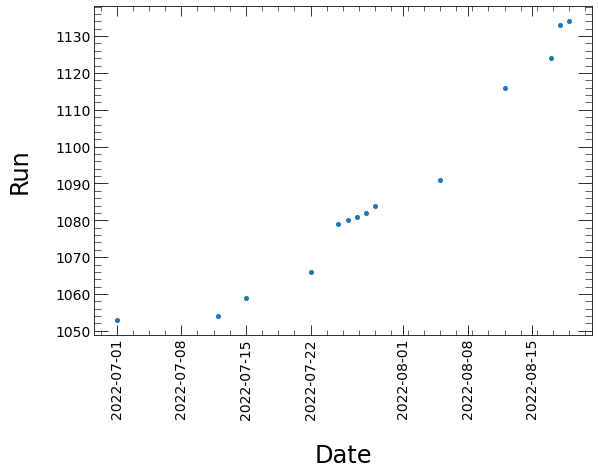

In [120]:
plt.plot(df['date'], df['run'], '.')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Run');

#Make plots

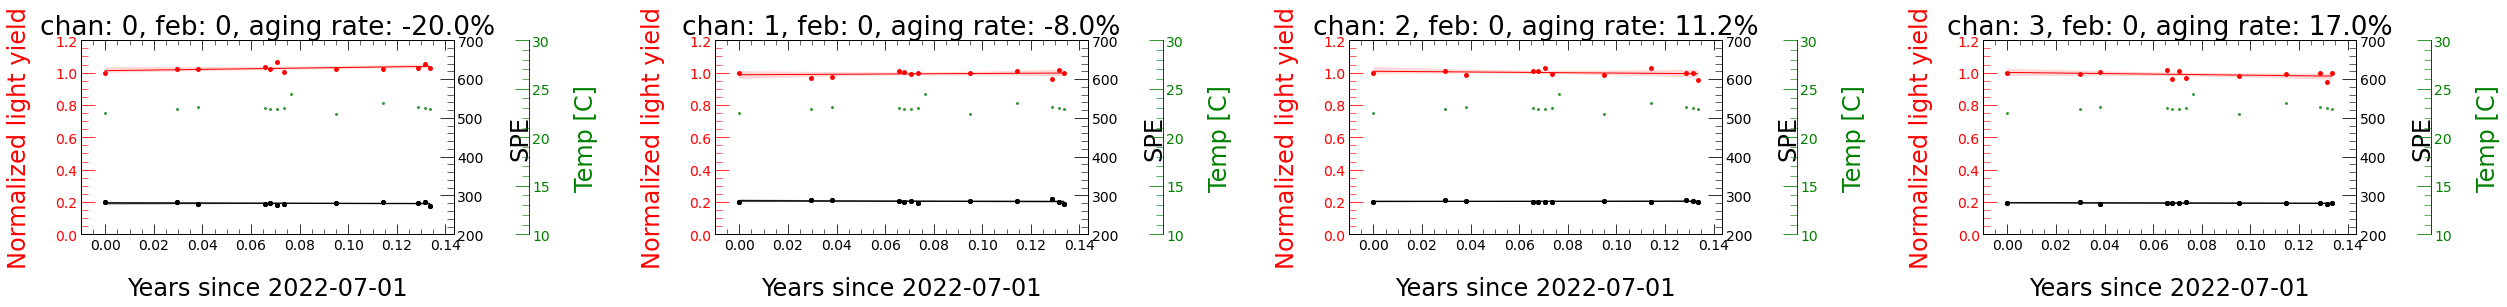

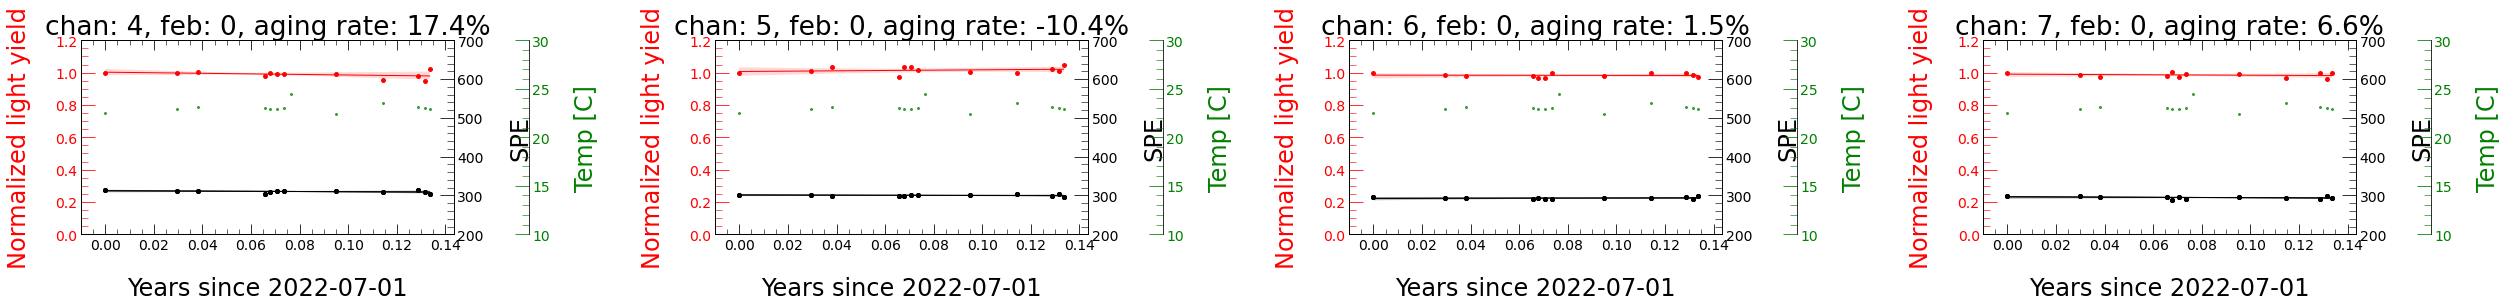

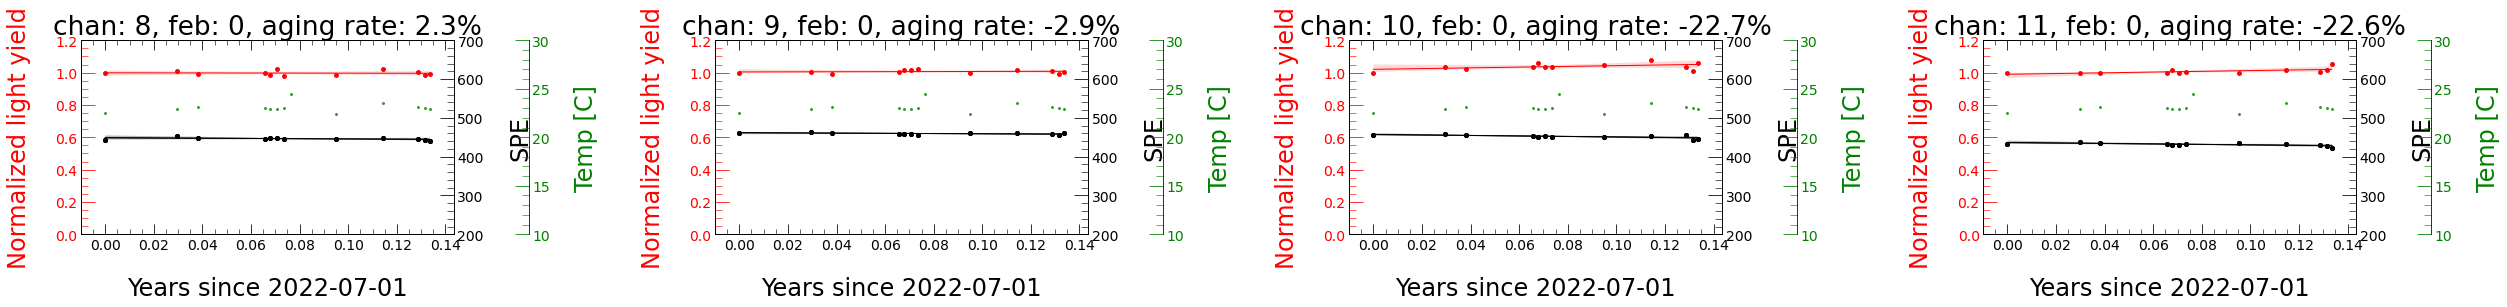

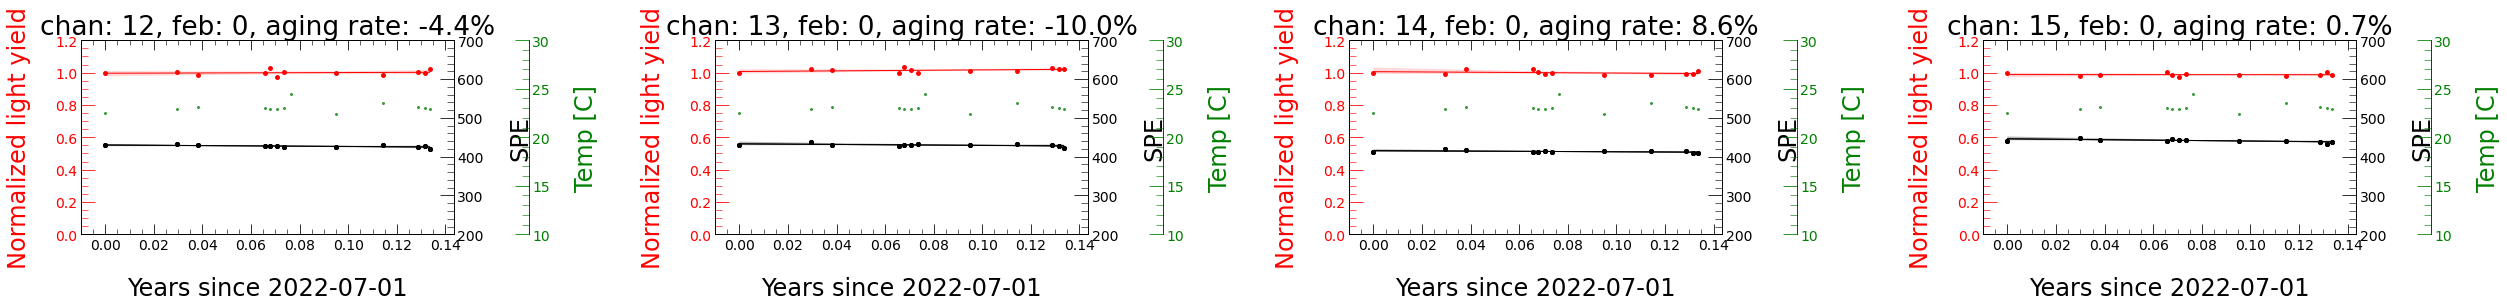

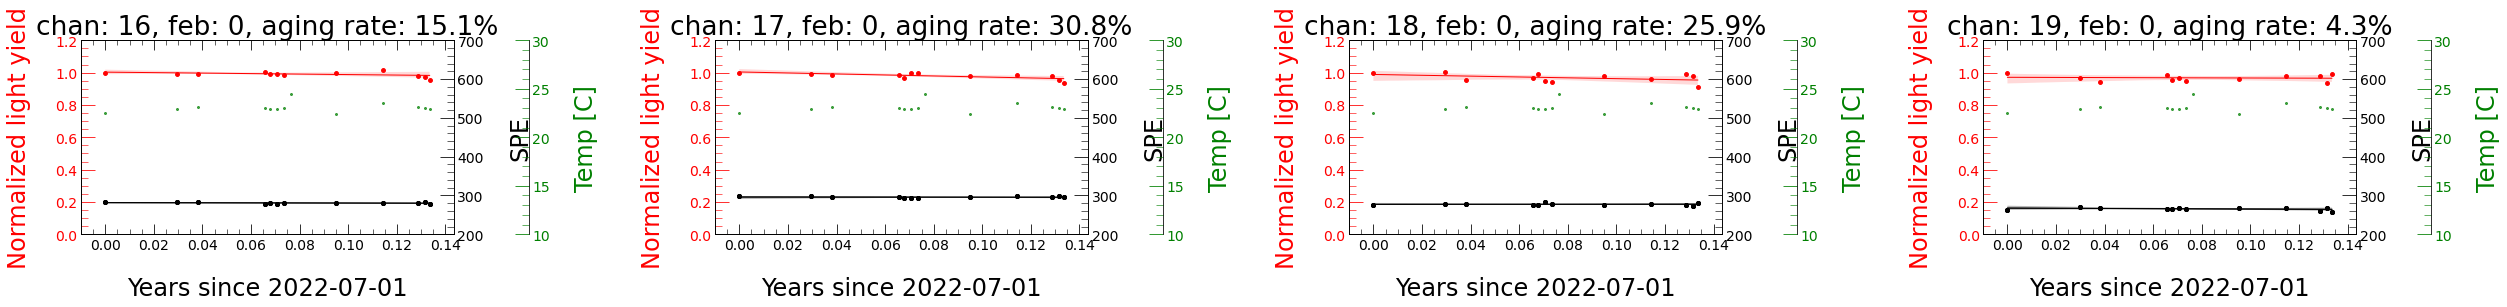

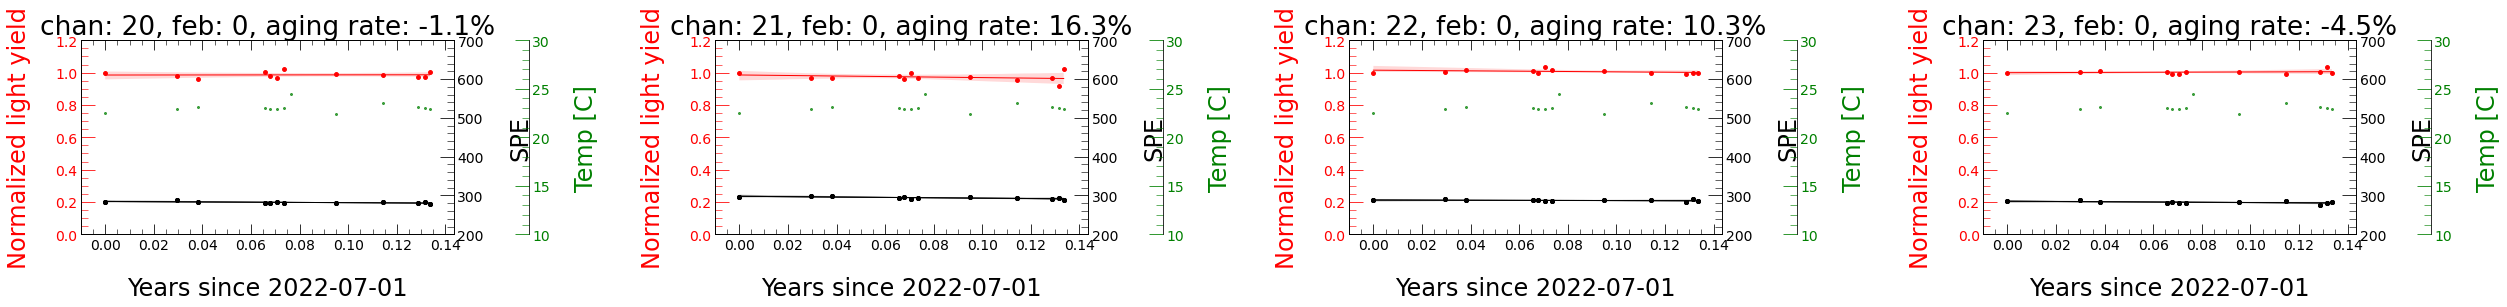

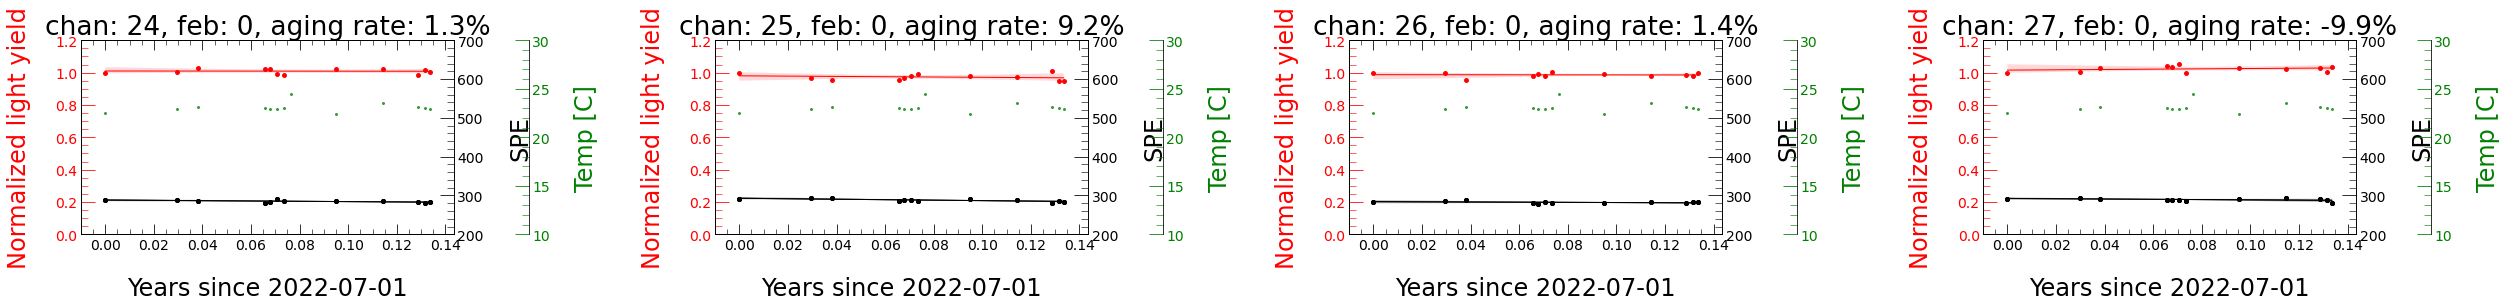

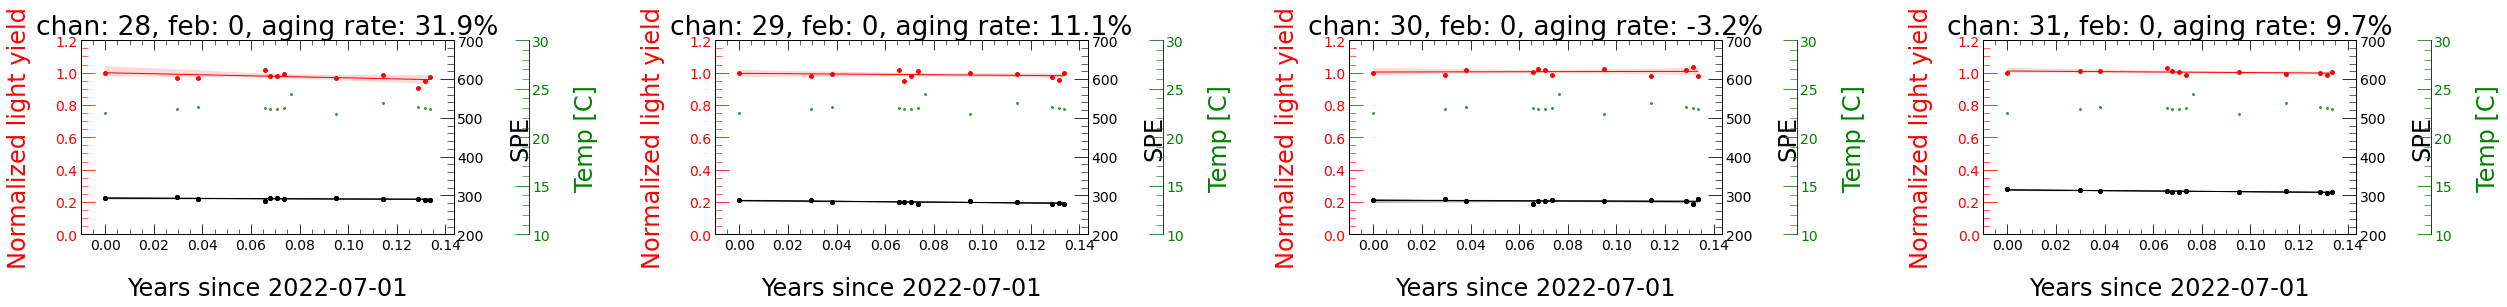

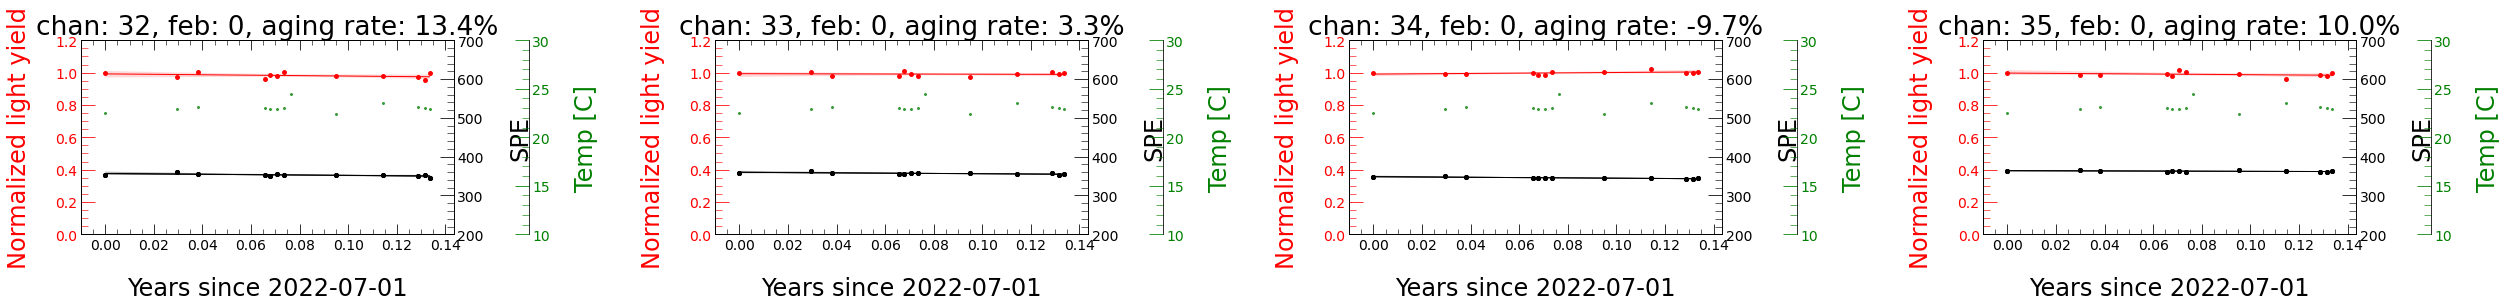

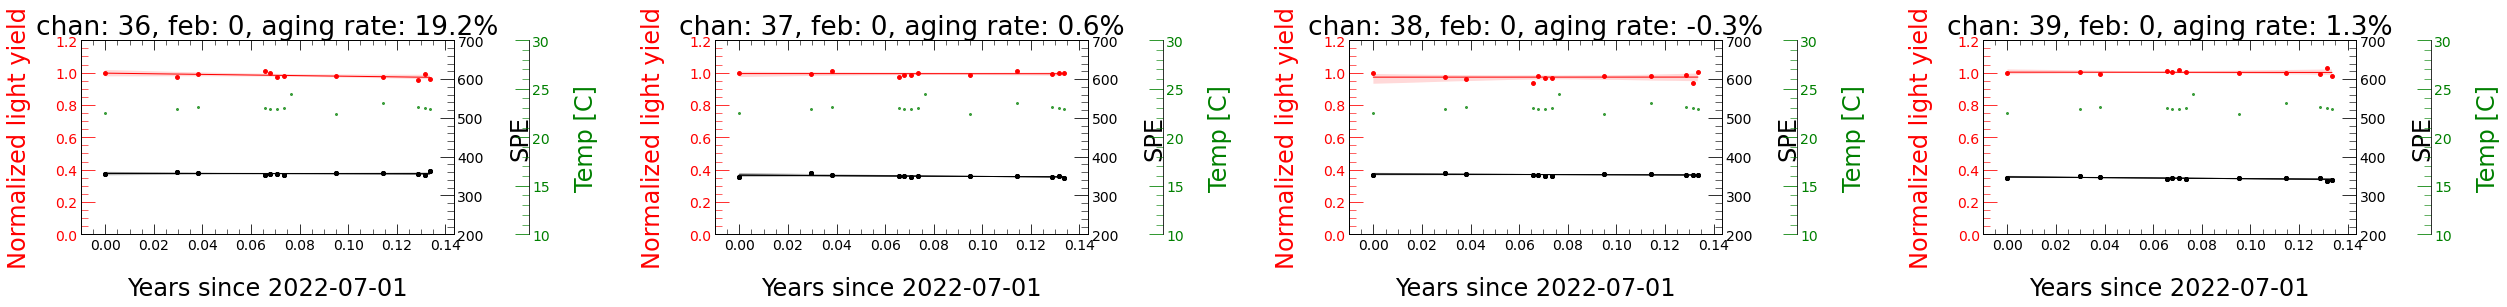

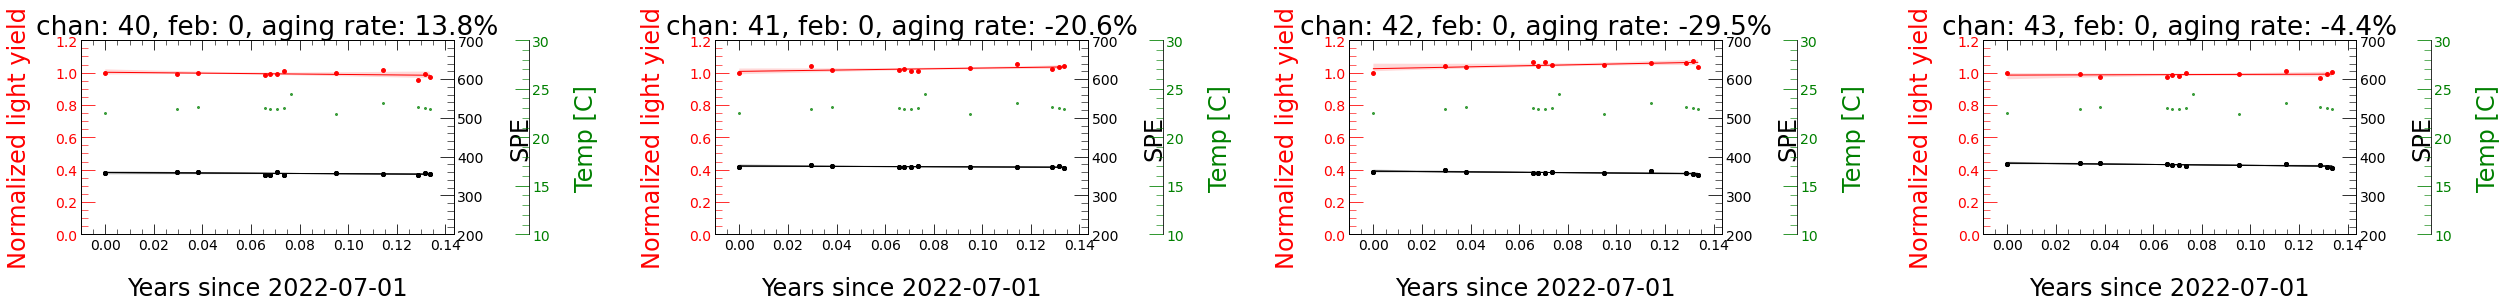

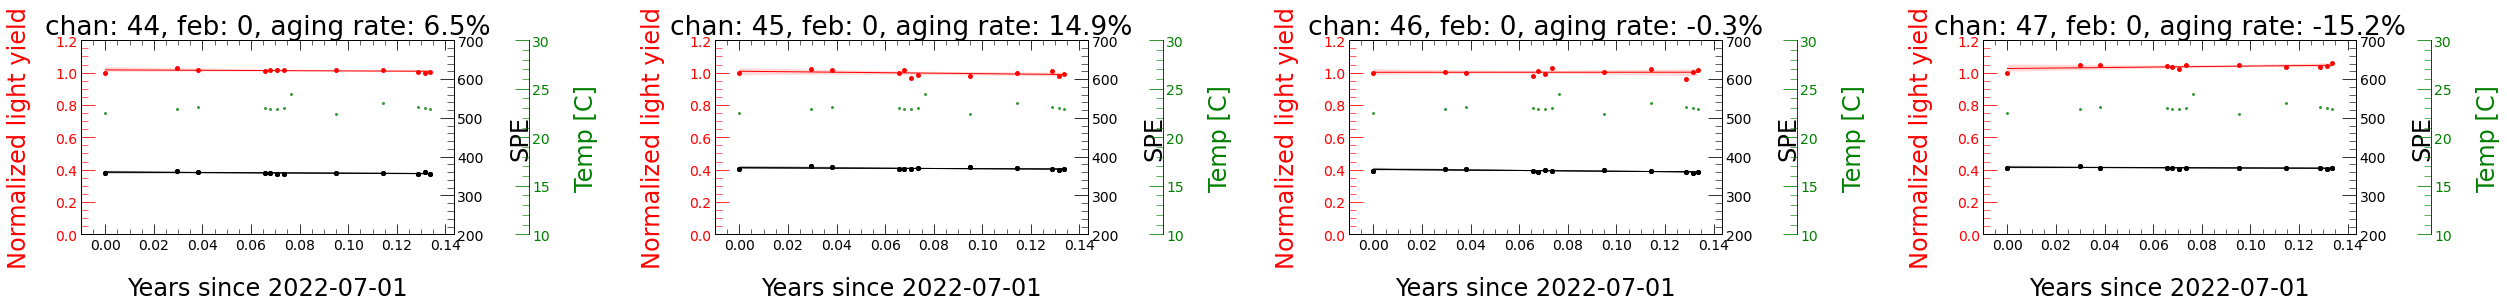

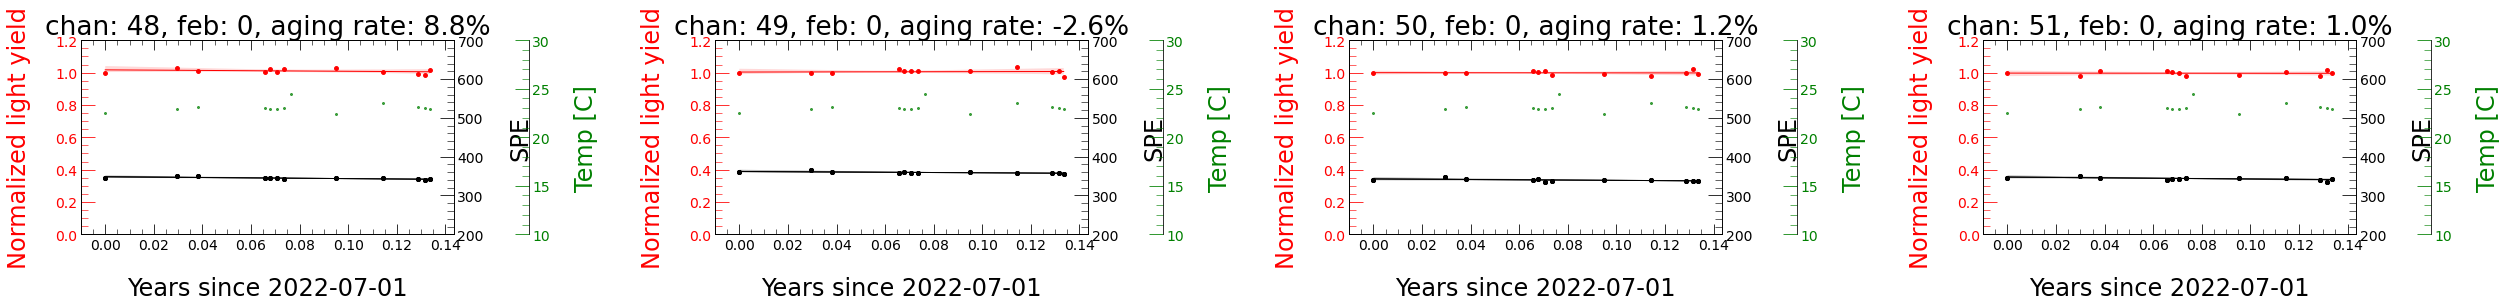

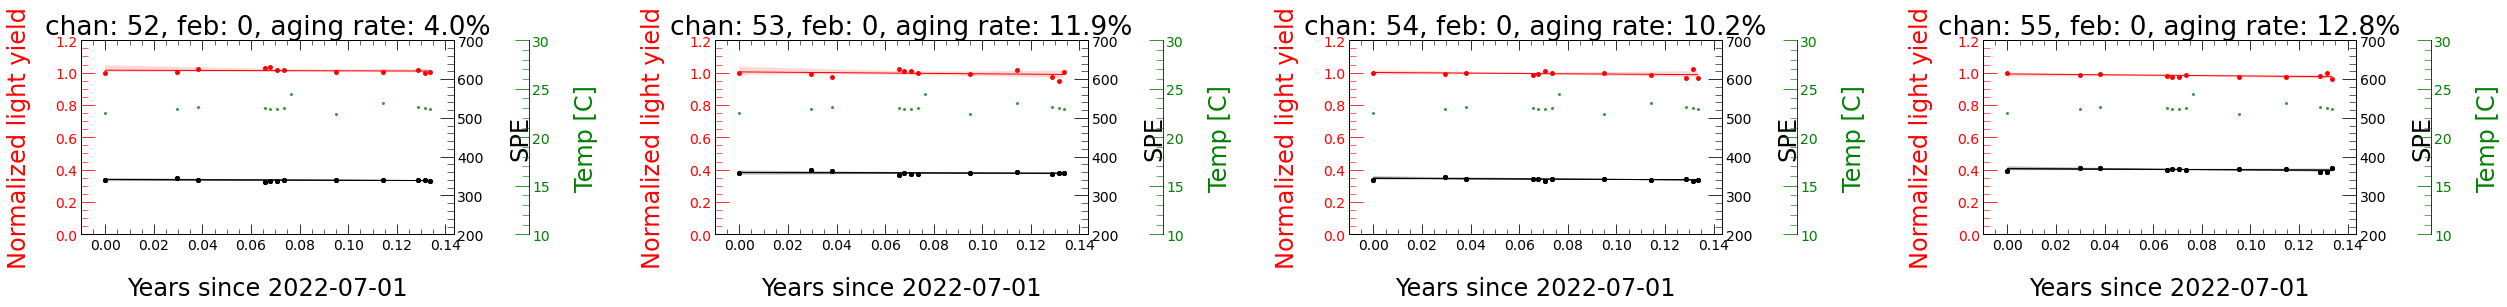

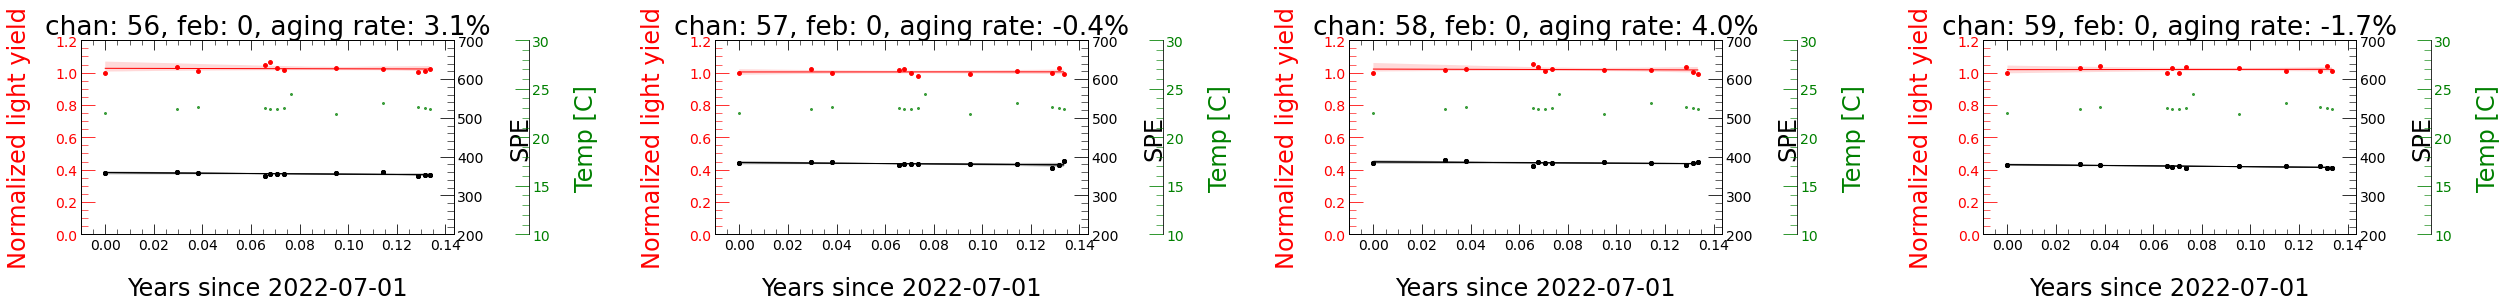

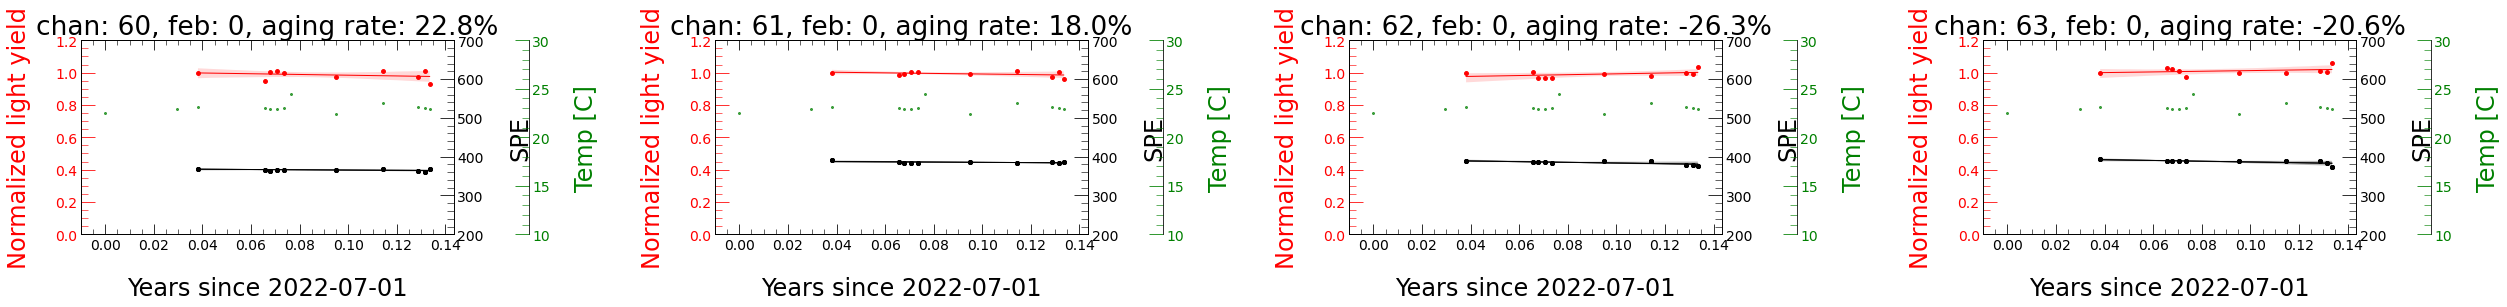

In [112]:
aging_pct=[]
#hdmi_range=list(range(0, 6))+list(range(8, 14))
hdmi_range=list(range(0, 16))
t0=str(df['date'].to_numpy()[0])

for feb in range(0, 1):
  for hdmi in hdmi_range:
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.7)

    for chan in range(0, 4):
      ax2 = ax1[chan].twinx()
      ax3 = ax1[chan].twinx()
      ax3.spines['right'].set_position(("axes", 1.2))

      #Plot normalized PE over years
      chan_infeb = hdmi*4+chan
      x=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['years'].to_numpy()
      y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['PEsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      y=y/y[0]

      #Fit the aging curve
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax1[chan], color='red', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
      ax1[chan].set_title('chan: %d, feb: %d, aging rate: %.1f%%'%(hdmi*4+chan,feb,-slope*100))
      ax1[chan].set_ylim(0,1.2)
      ax1[chan].set_xlim(-0.01, x.max()+0.01)
      ax1[chan].set_xlabel("Years since %s"%t0)
      ax1[chan].set_ylabel('Normalized light yield', color='r')
      ax1[chan].tick_params(axis='y', which='both', colors='r')

      #Plot temp corr SPE over time
      y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['calibConstantsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax2, color='black', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      ax2.plot(x, y , 'k.')
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax2, color='black', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      ax2.set_ylim(200,700)
      ax2.set_ylabel('SPE', color='k');

      #Plot temp over time
      ax3.plot(df['years'], df['meanTemperatures_0_0'], 'go', markersize=2.0, linewidth=0.5, alpha=0.7)
      ax3.set_ylabel('Temp [C]', color='g')
      ax3.set_ylim(10,30)
      ax3.tick_params(axis='y', which='both', colors='g')

      #Append aging for FEB0 only.
      if(feb>0):
        aging_pct.append(-slope*100)

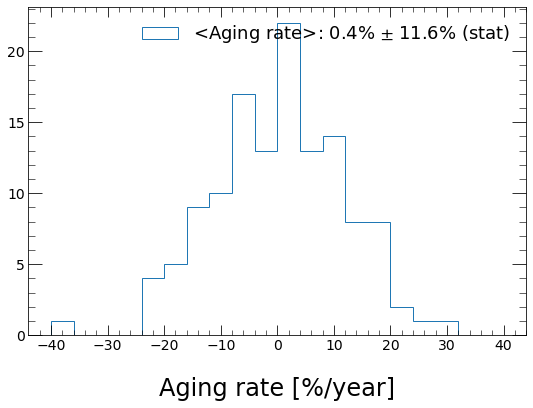

In [95]:
plt.hist(aging_pct, bins=20, range=(-40,40), histtype='step', label='<Aging rate>: %.1f%% $\pm$ %.1f%% (stat)'%(np.mean(aging_pct), np.std(aging_pct)) );
plt.xlabel('Aging rate [%/year]');
plt.legend();

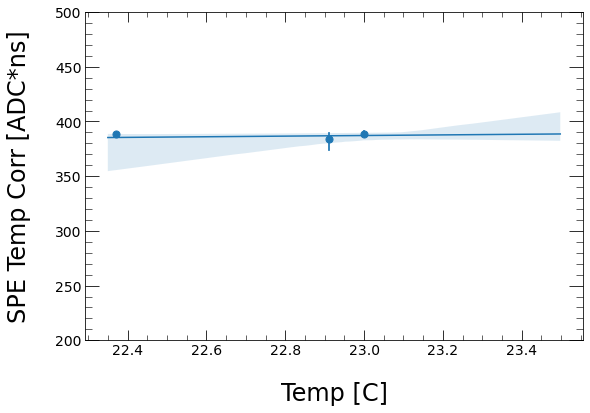

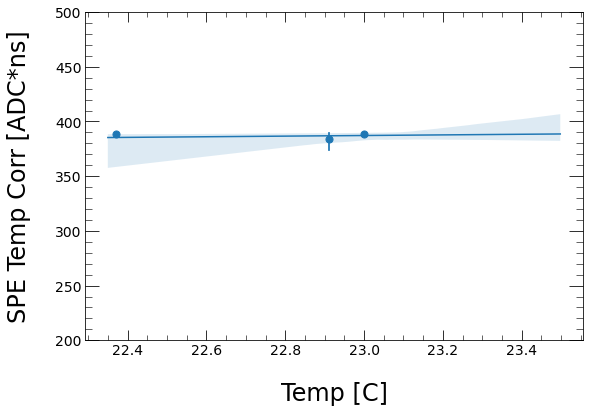

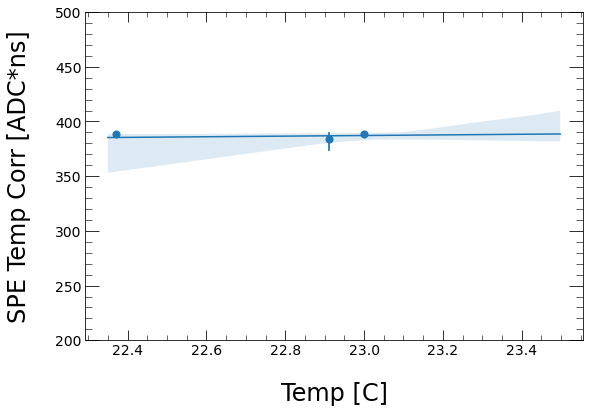

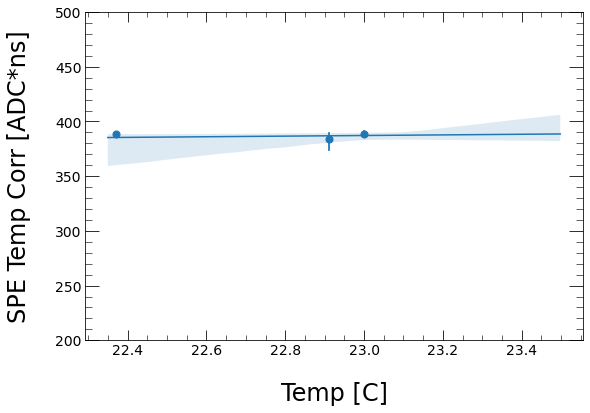

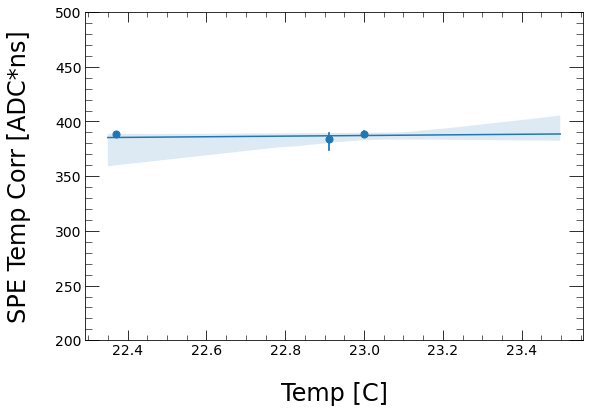

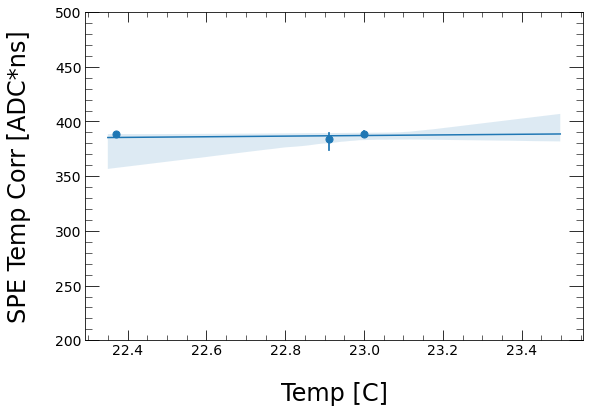

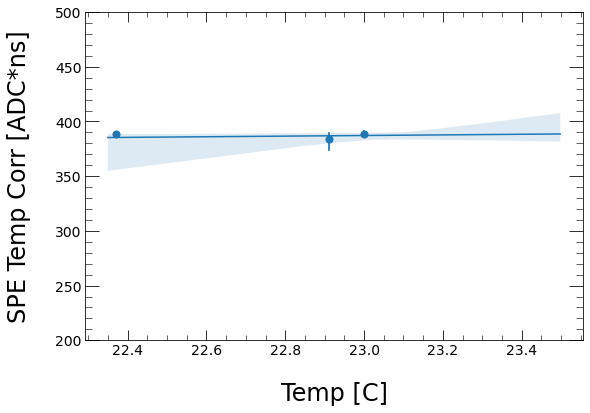

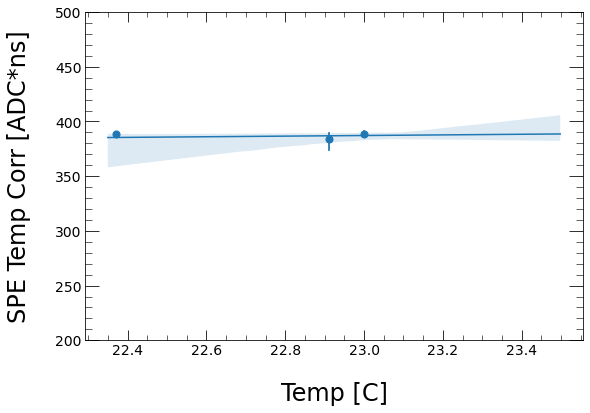

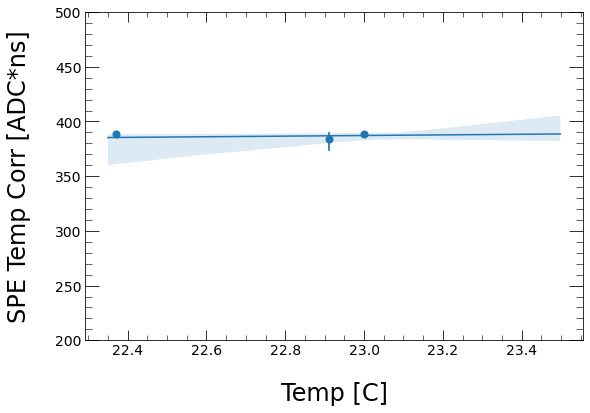

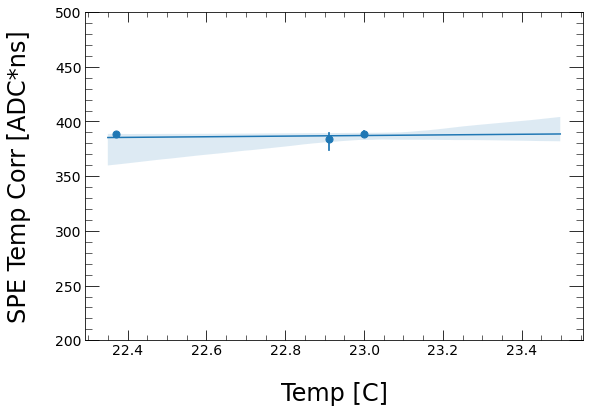

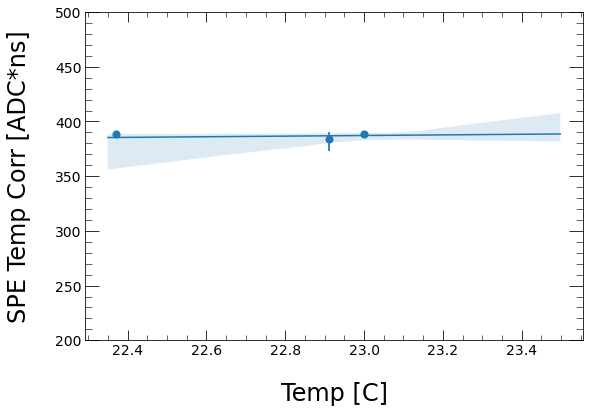

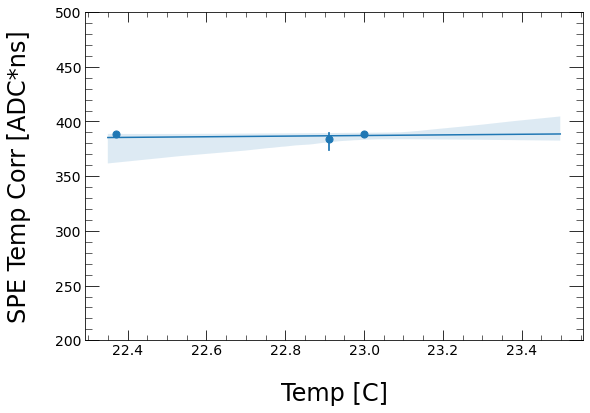

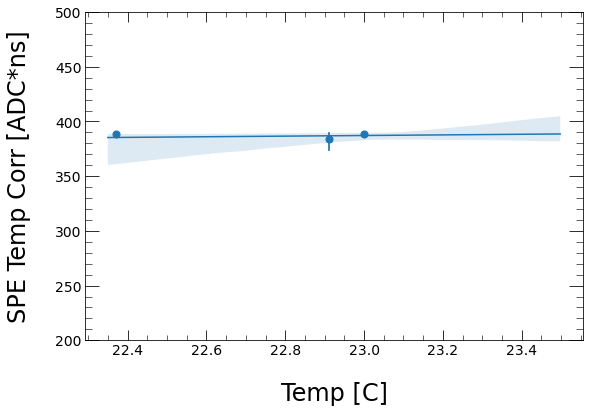

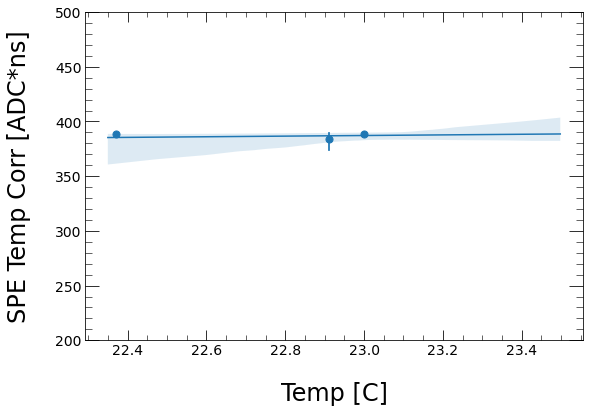

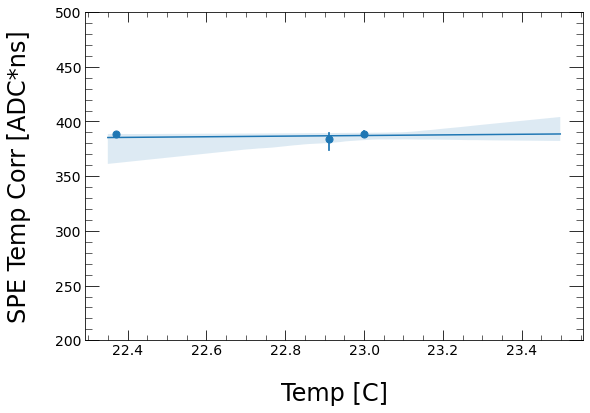

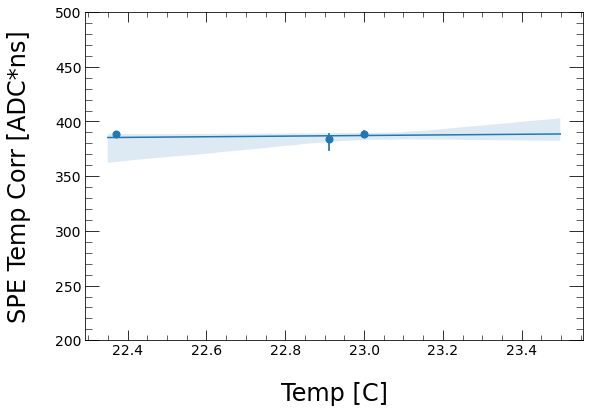

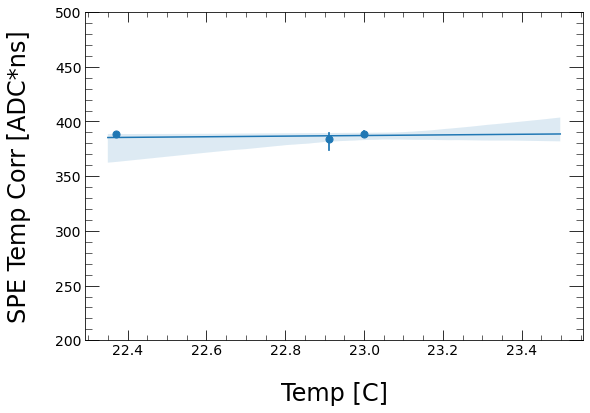

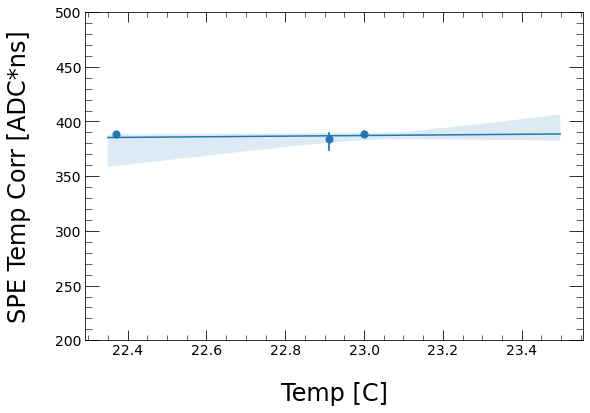

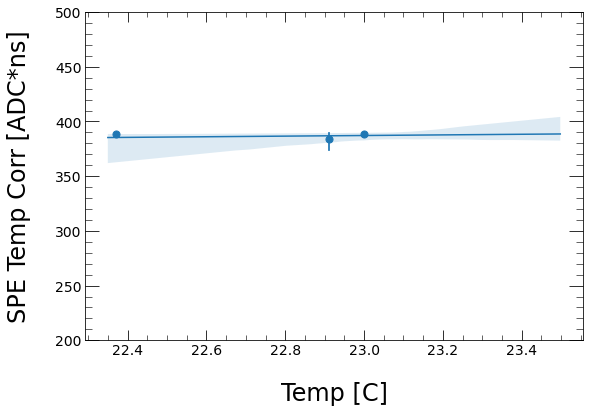

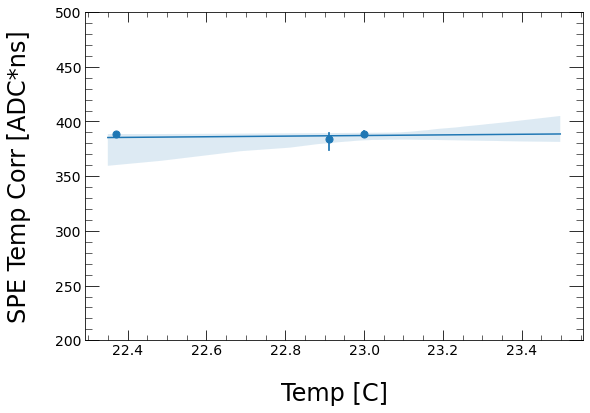

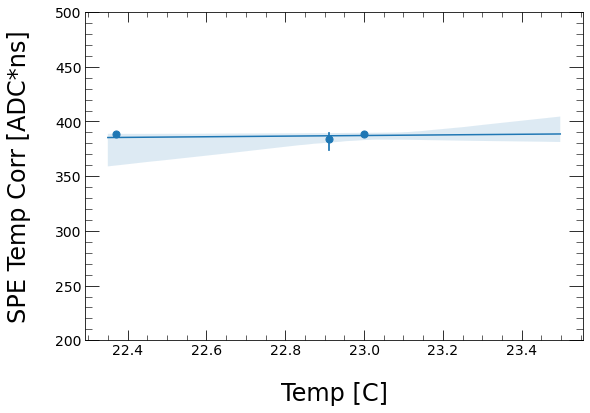

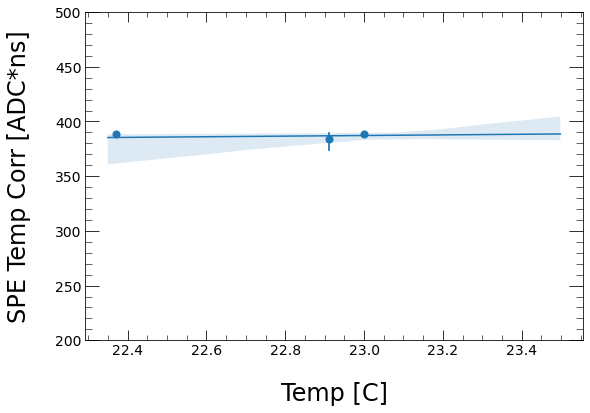

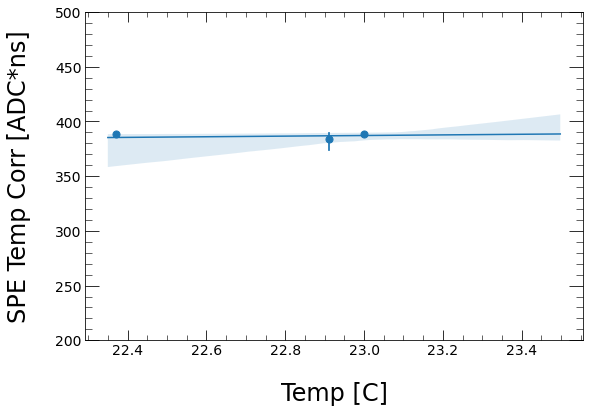

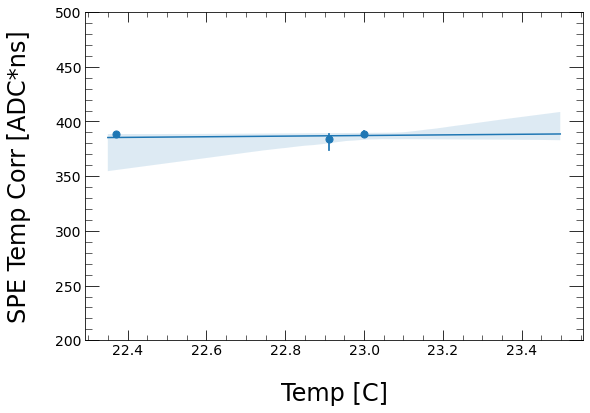

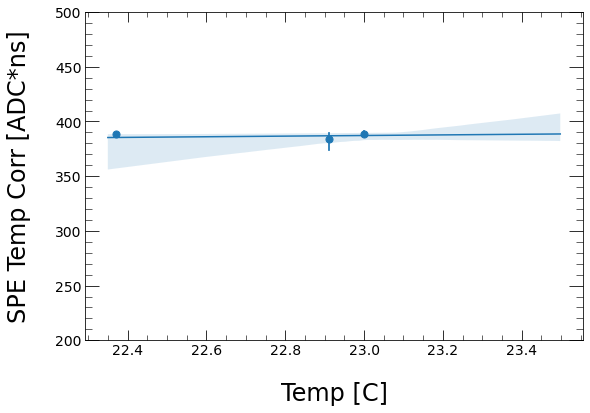

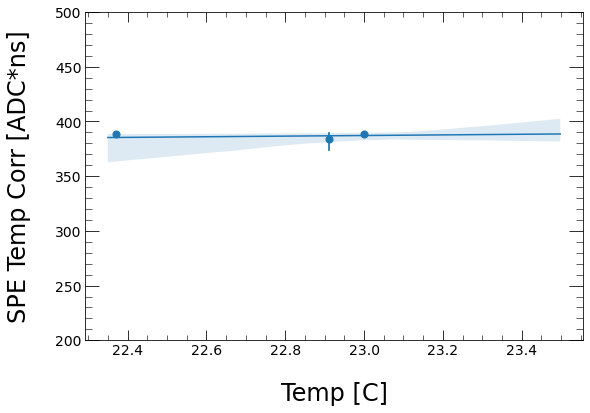

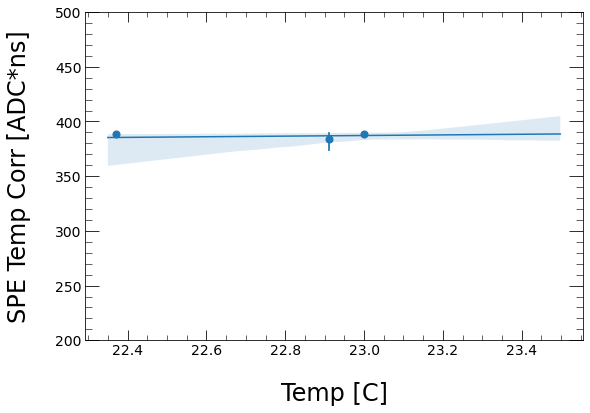

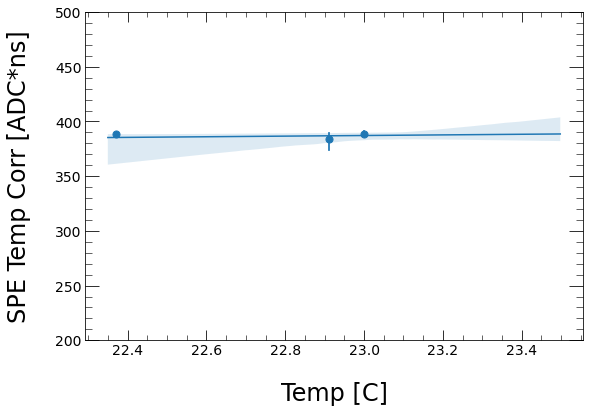

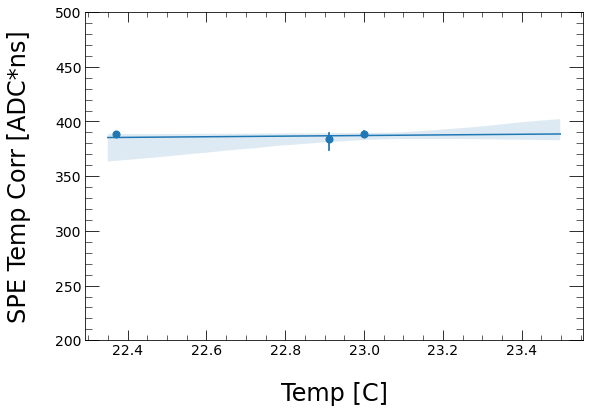

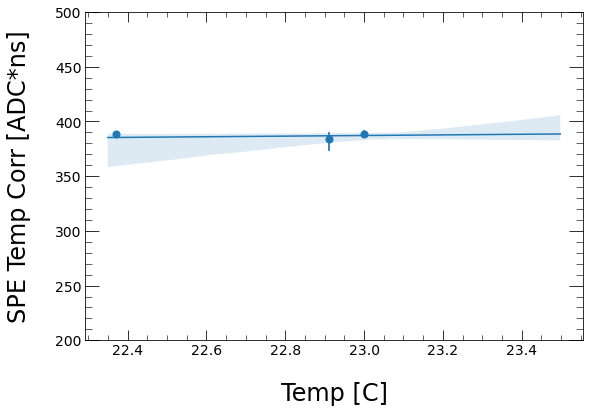

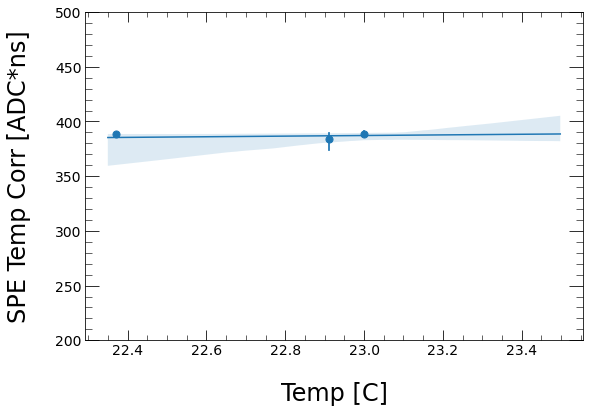

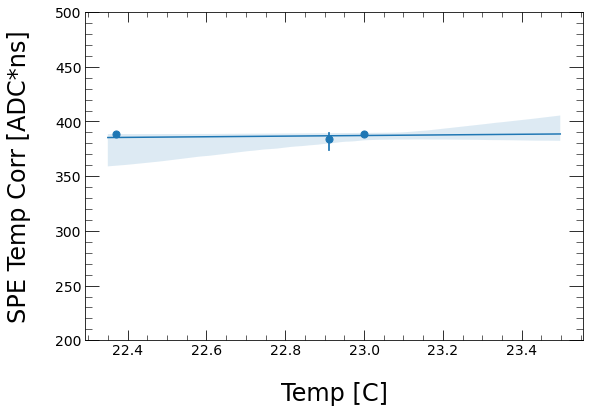

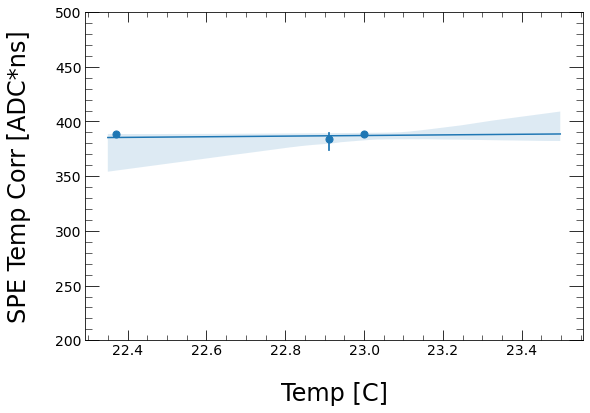

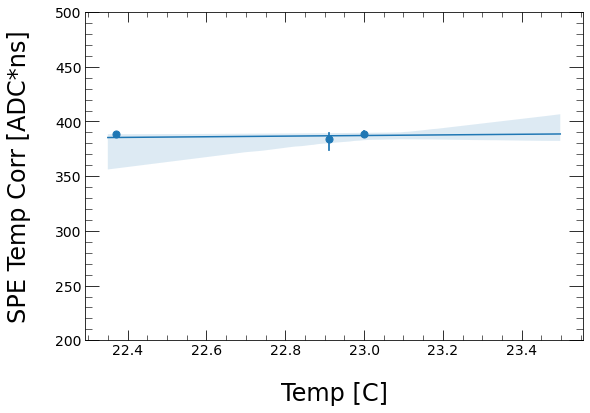

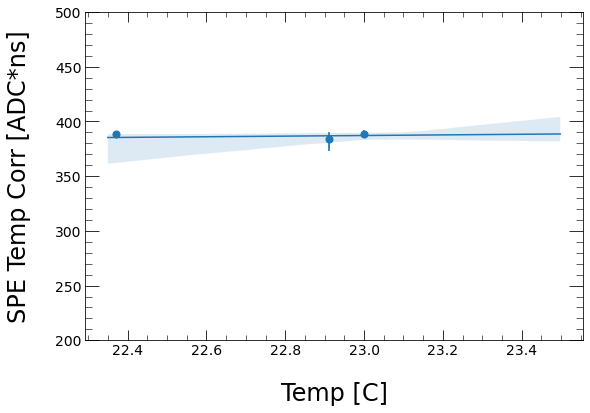

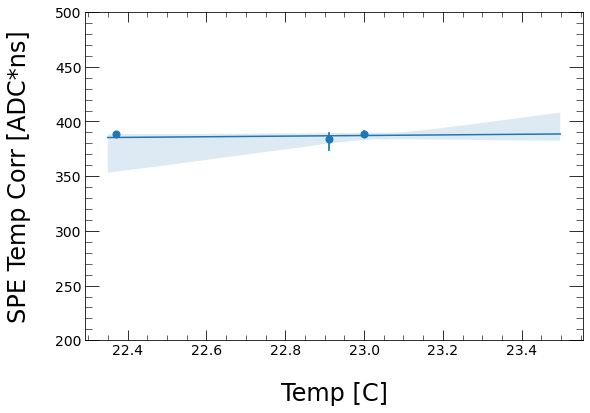

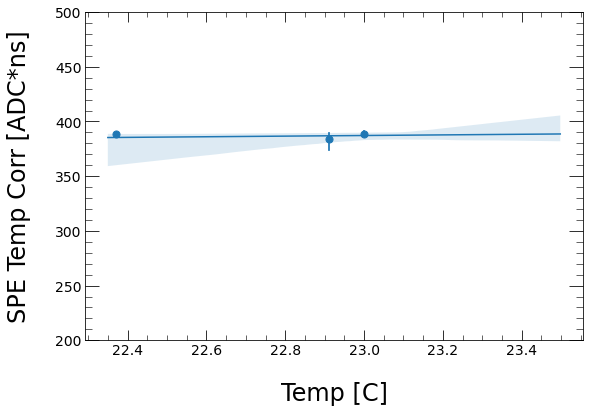

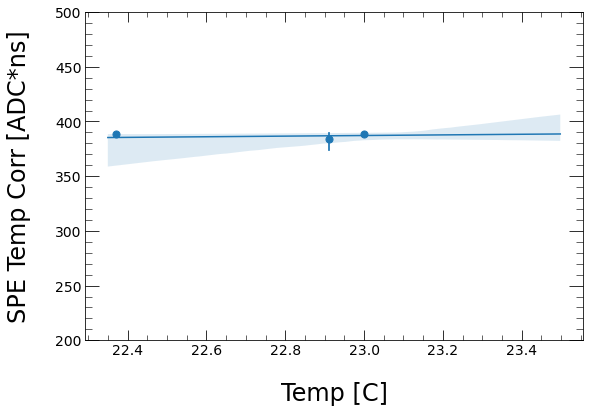

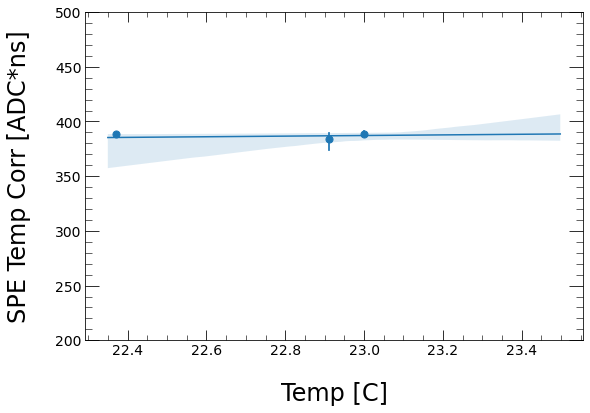

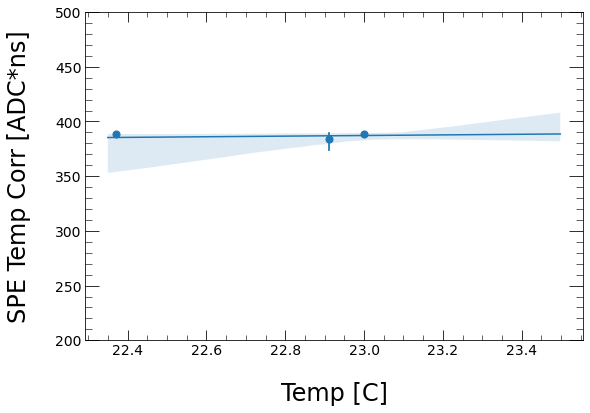

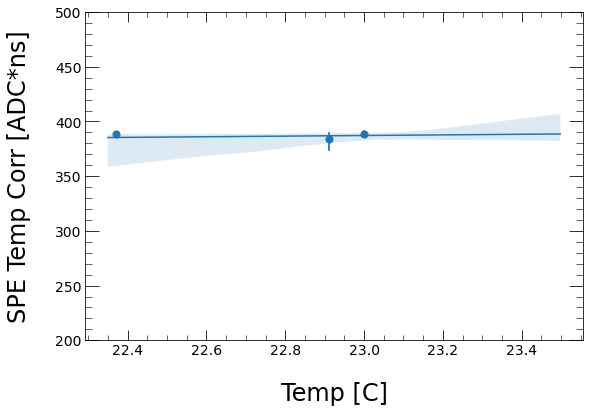

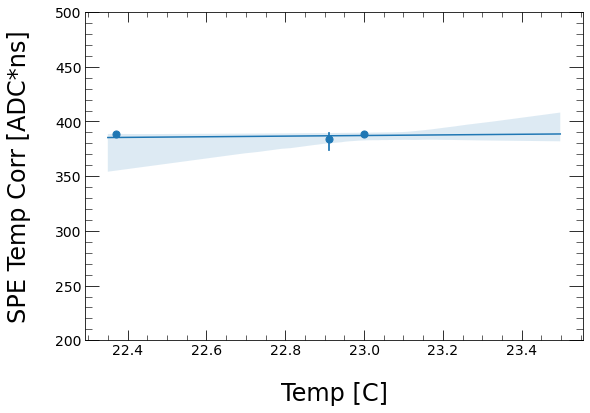

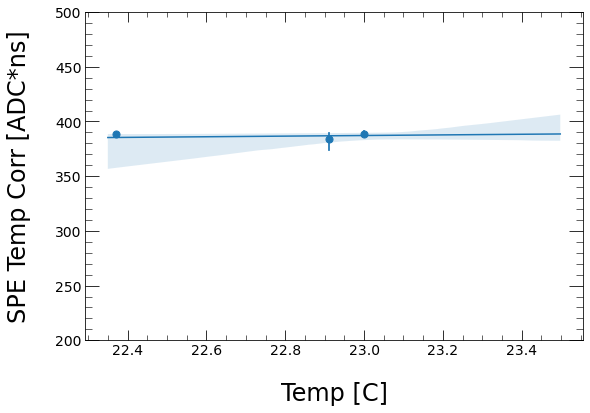

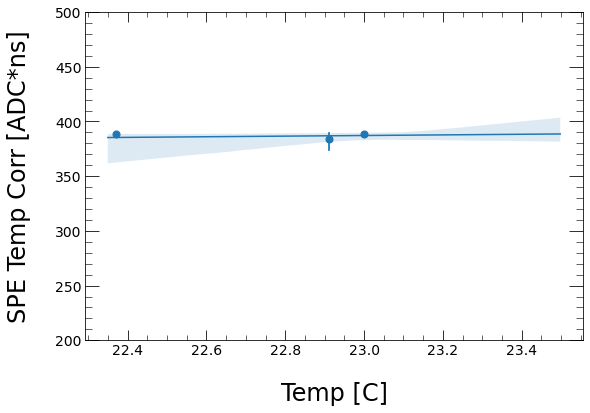

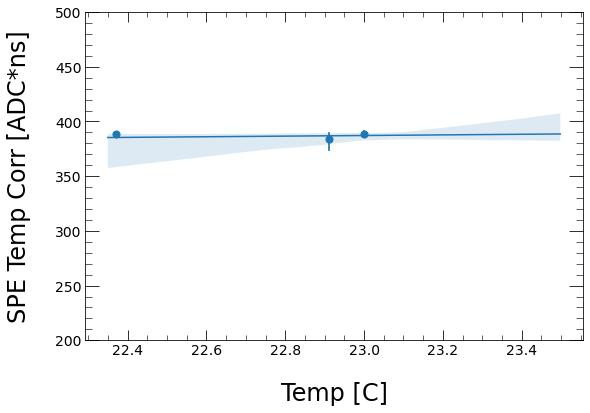

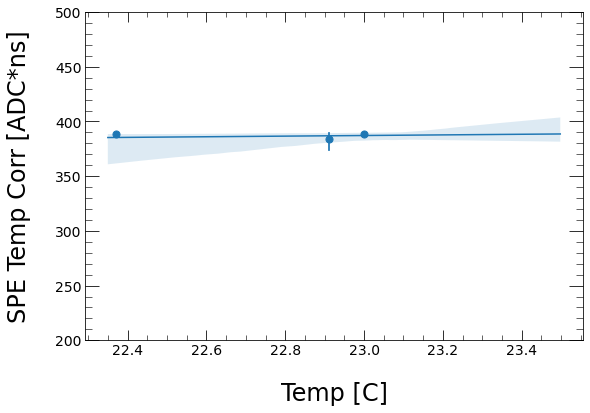

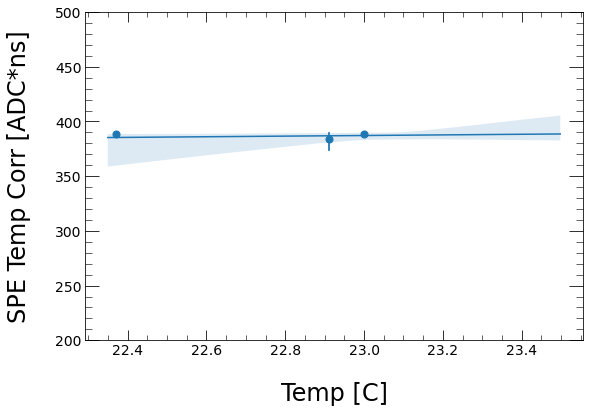

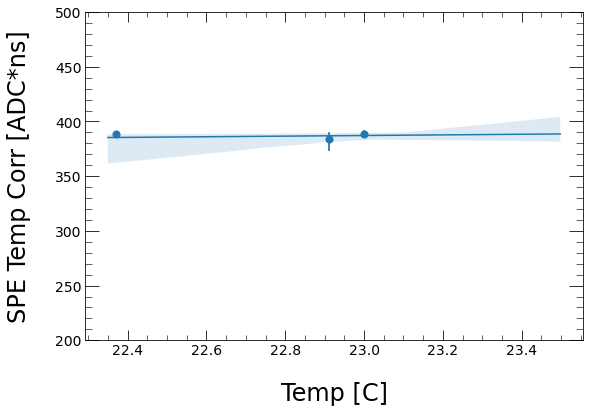

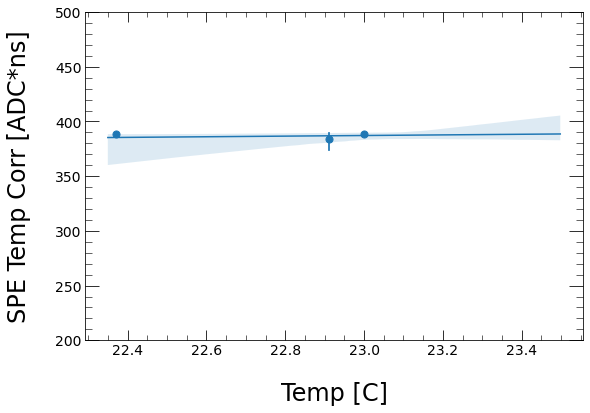

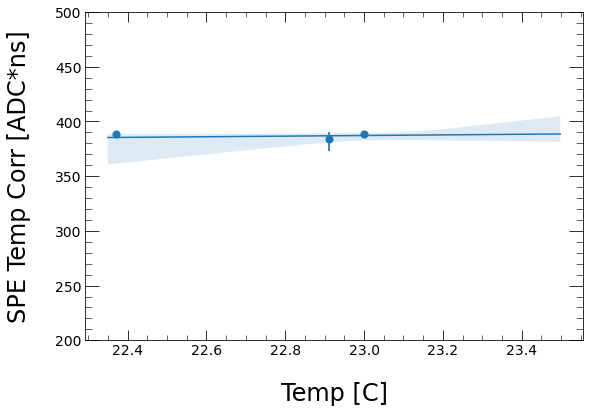

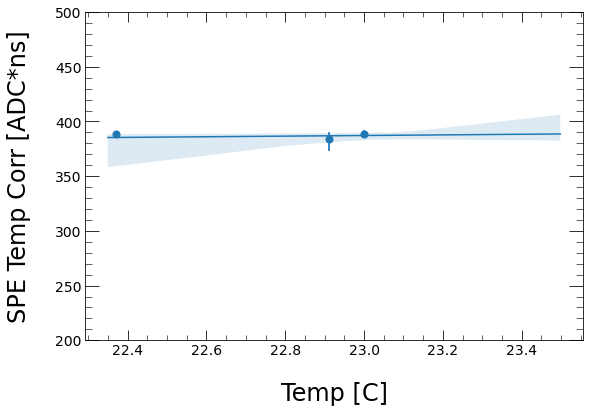

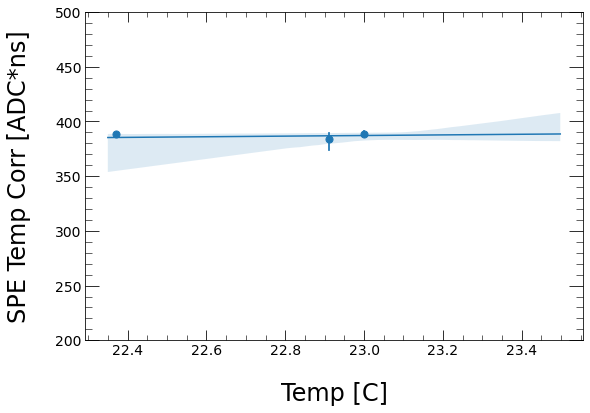

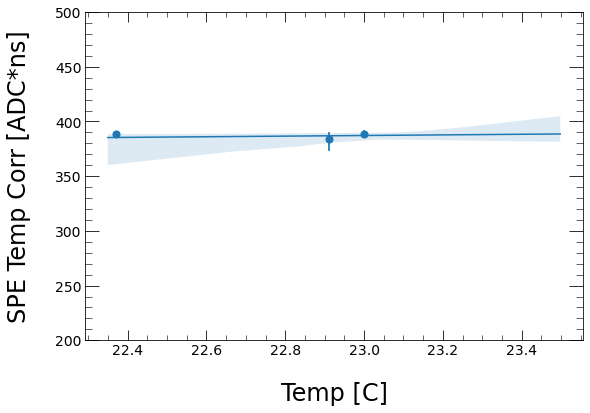

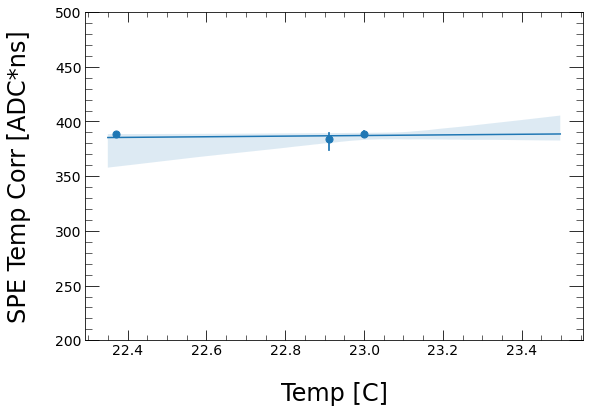

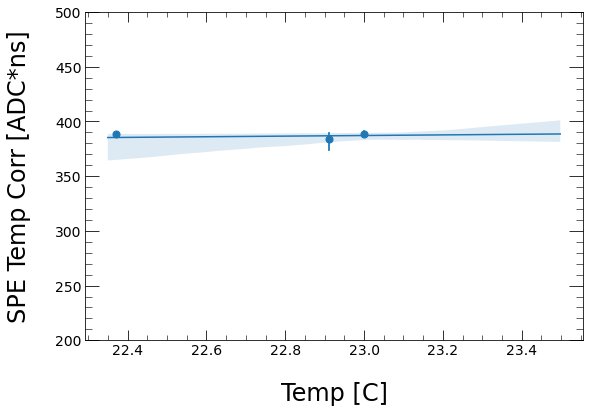

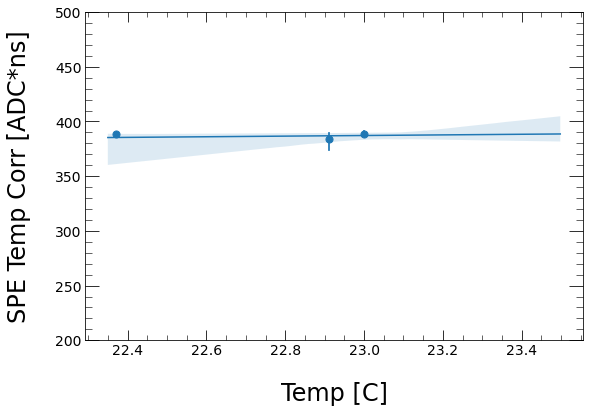

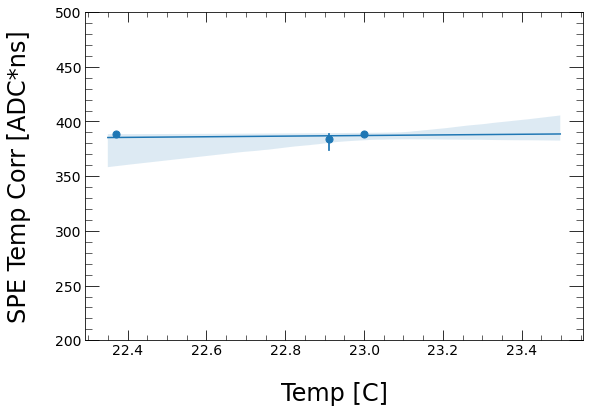

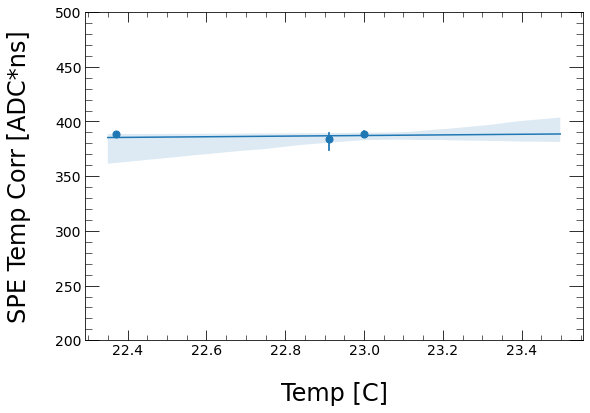

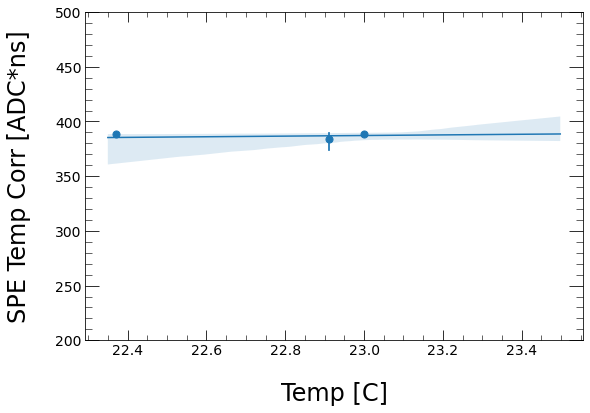

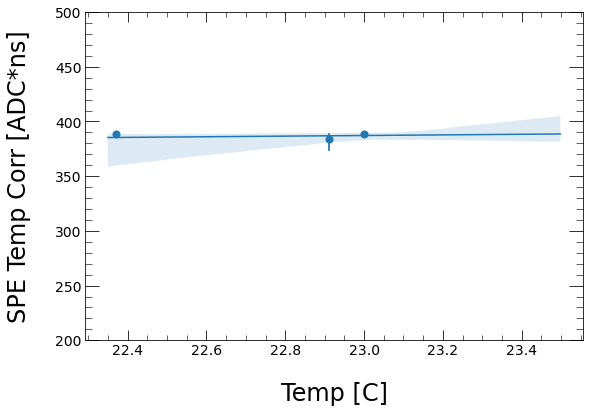

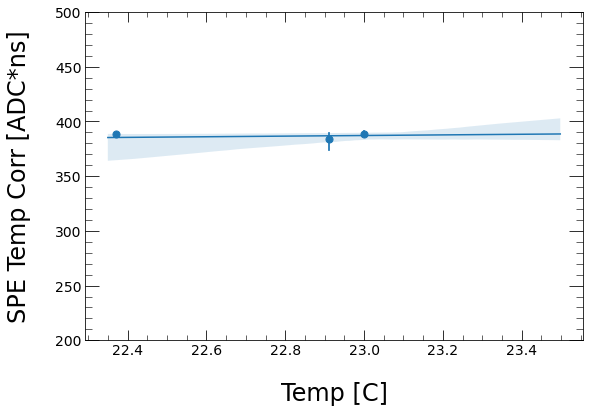

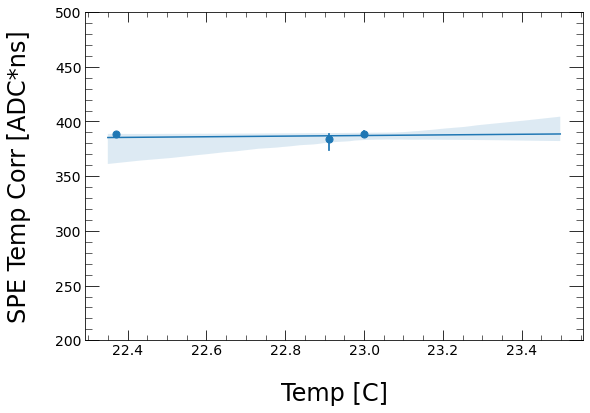

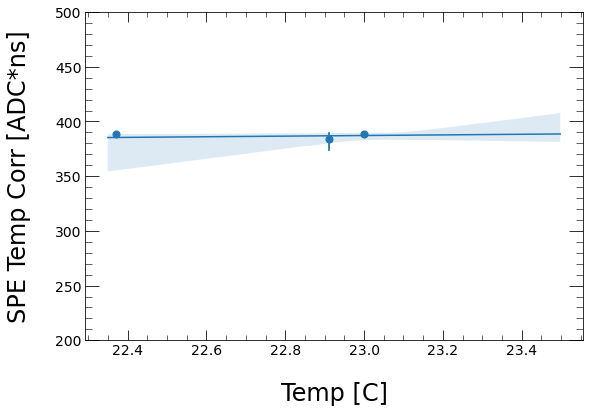

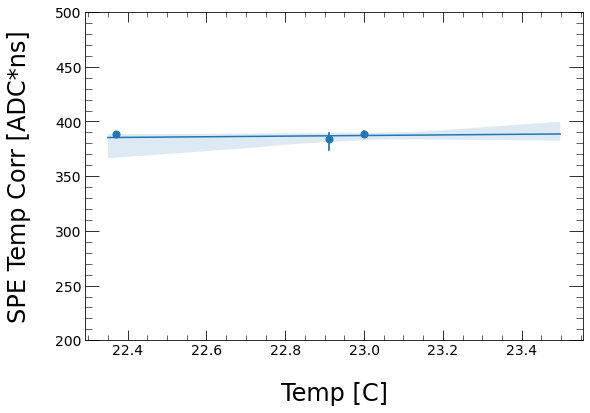

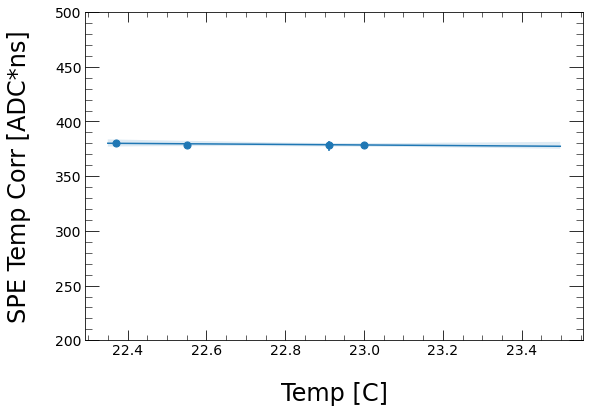

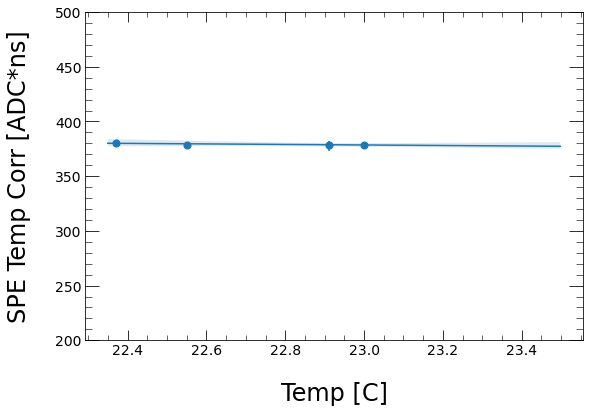

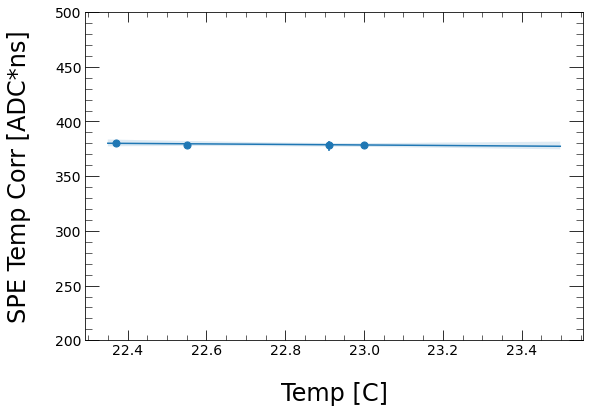

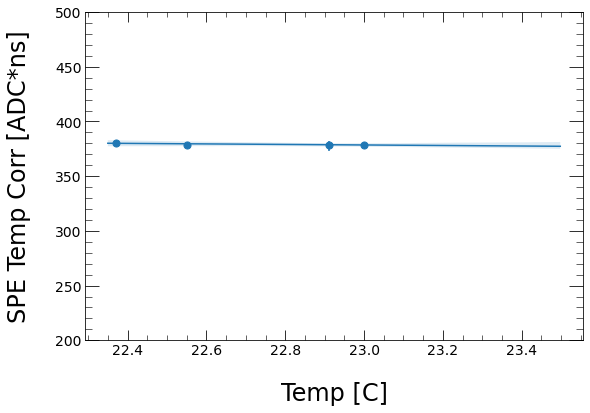

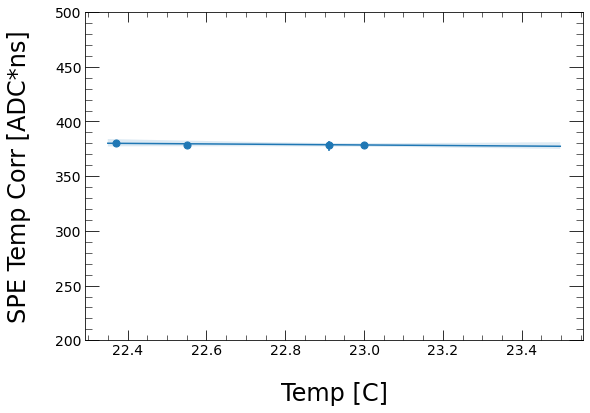

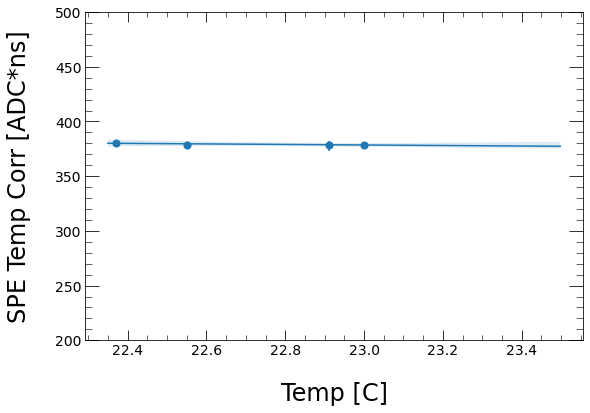

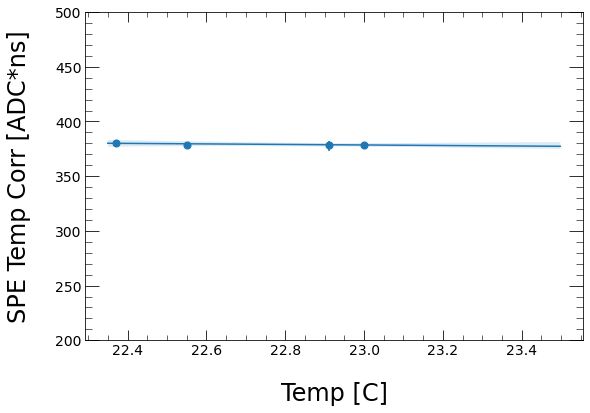

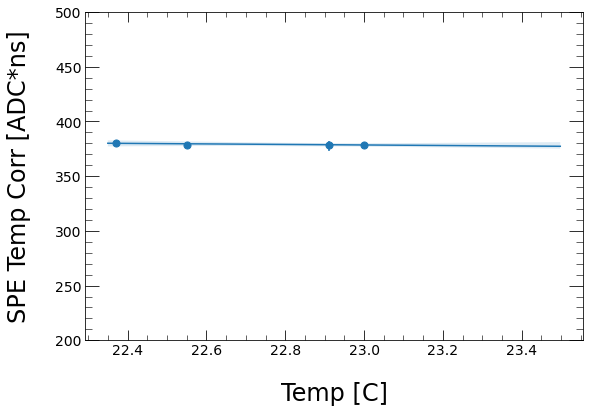

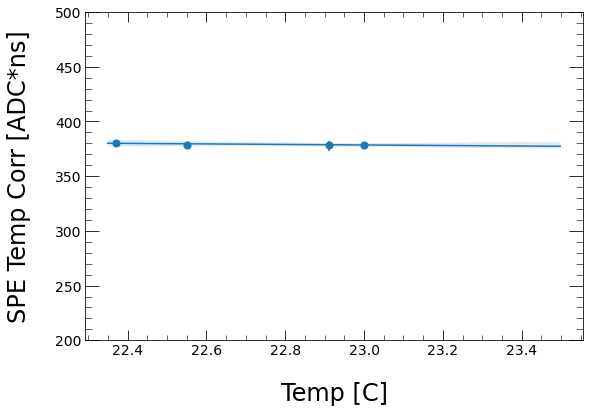

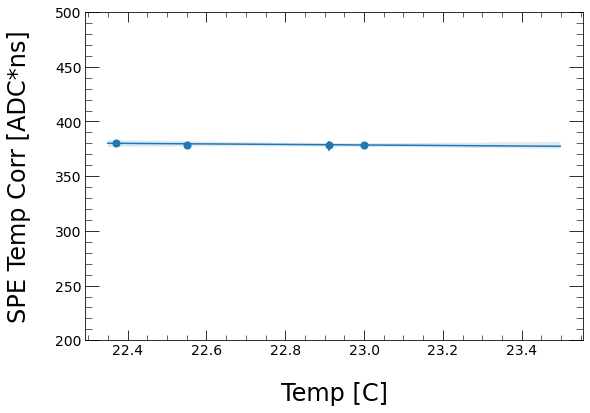

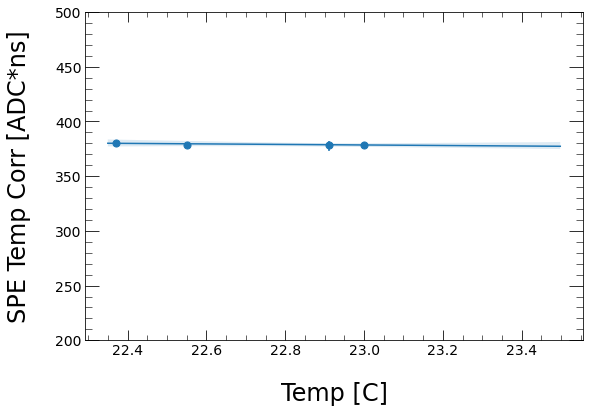

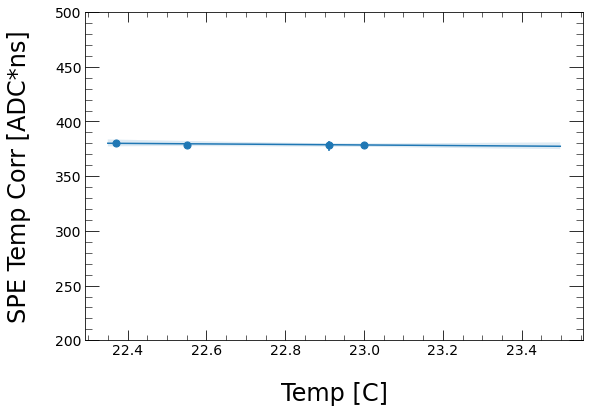

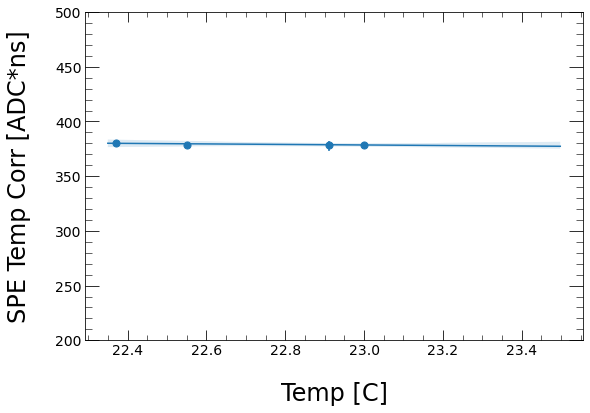

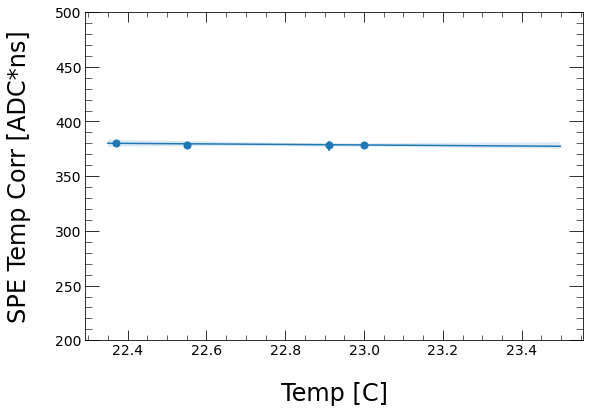

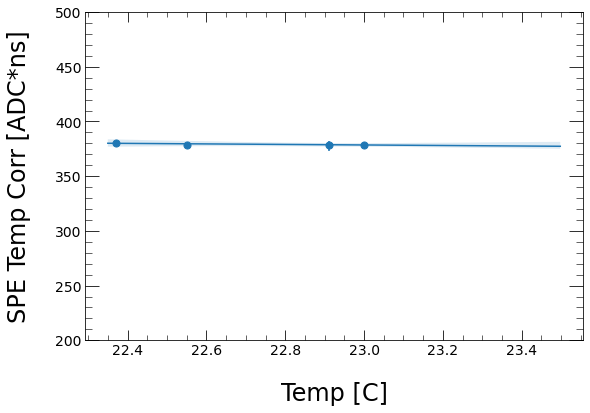

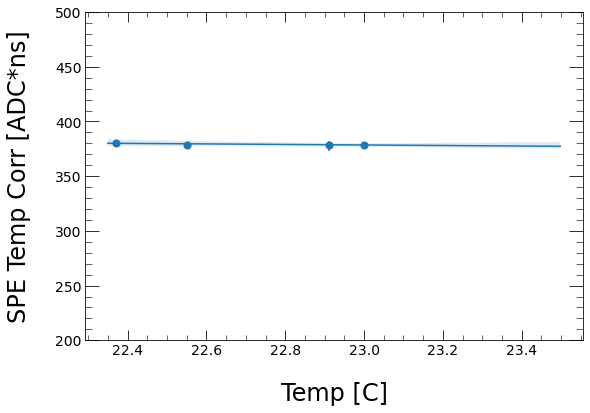

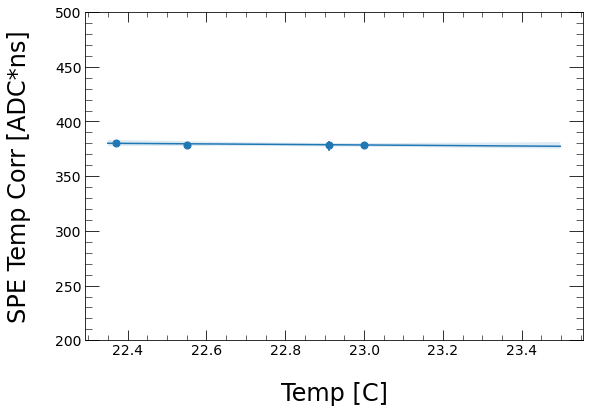

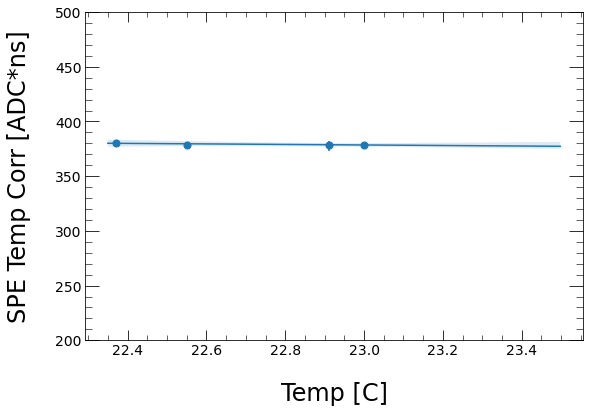

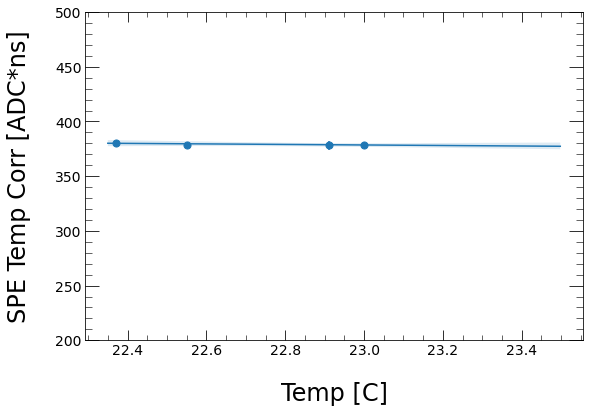

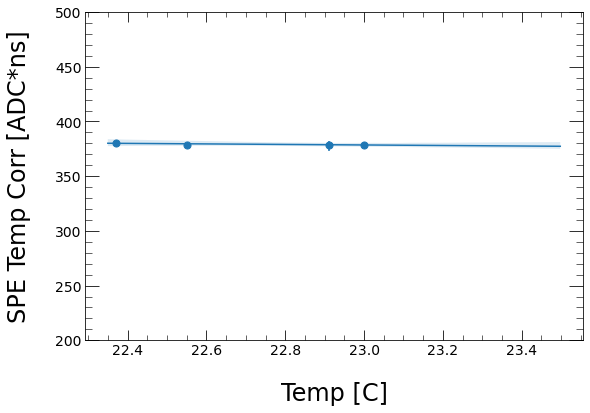

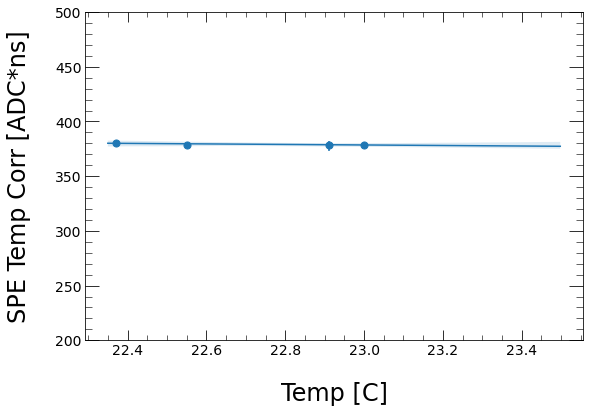

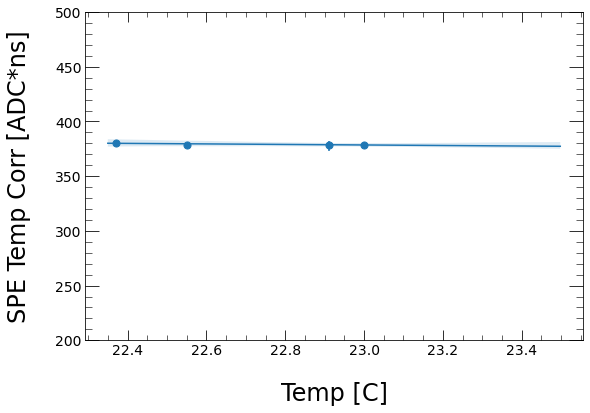

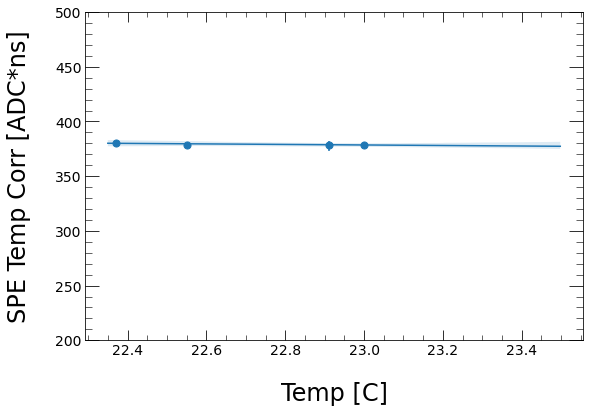

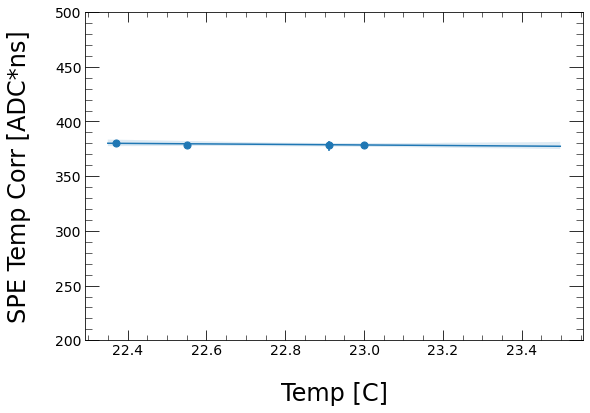

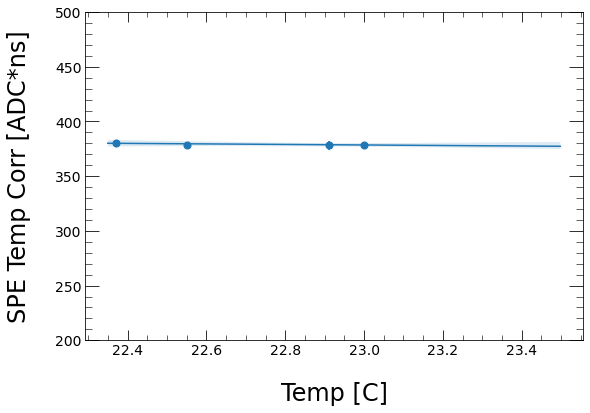

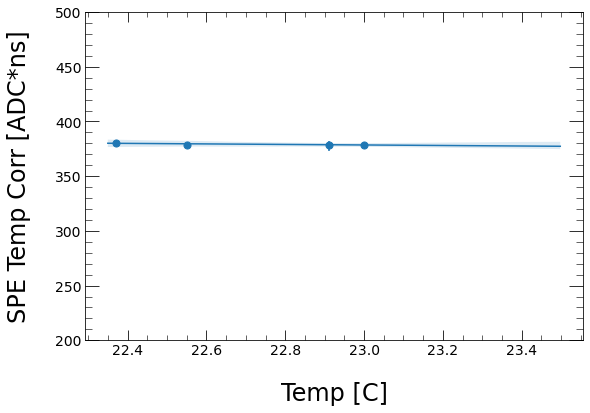

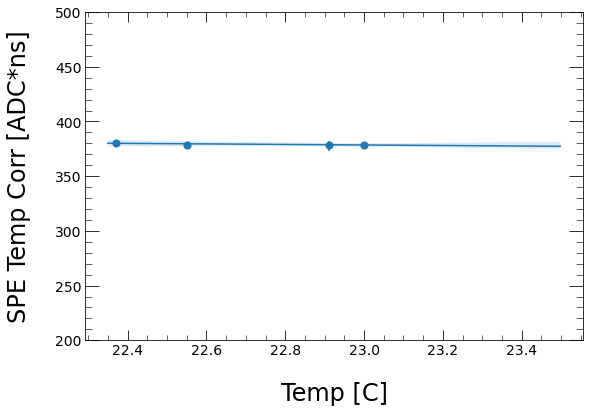

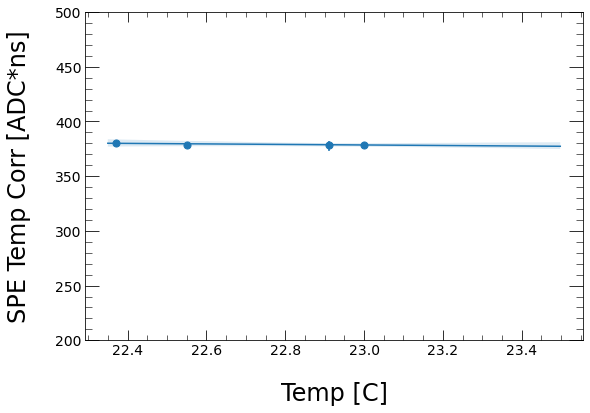

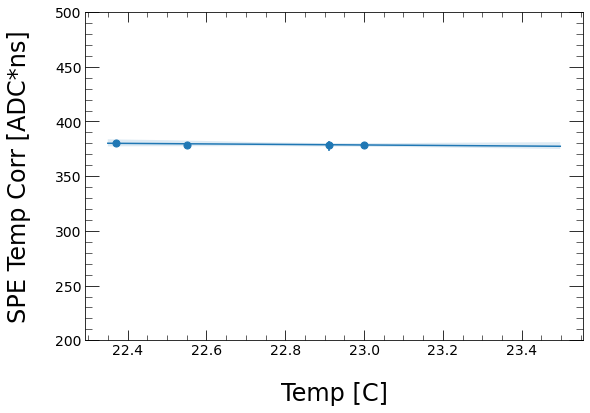

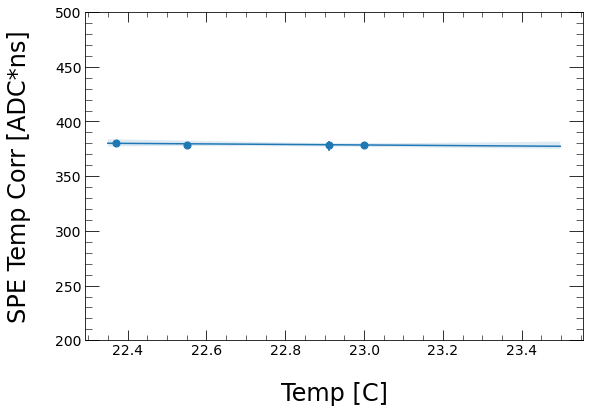

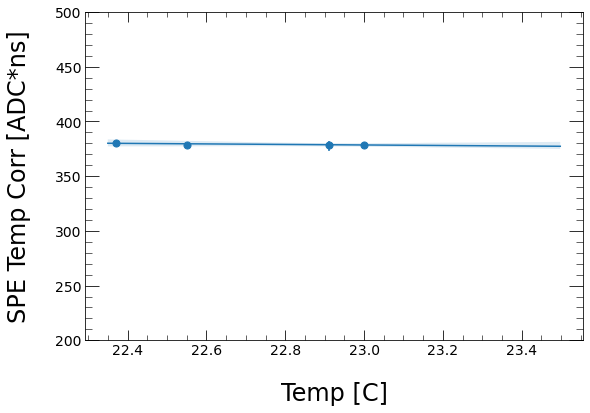

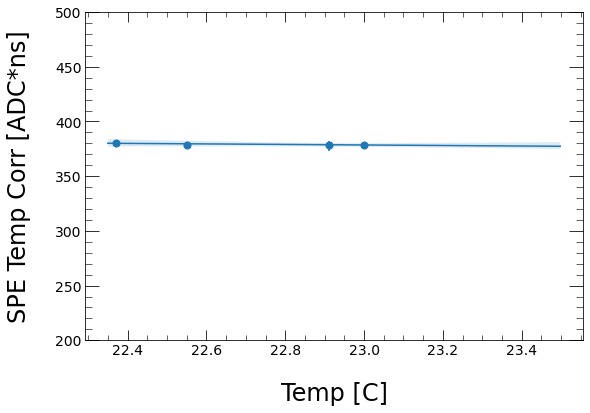

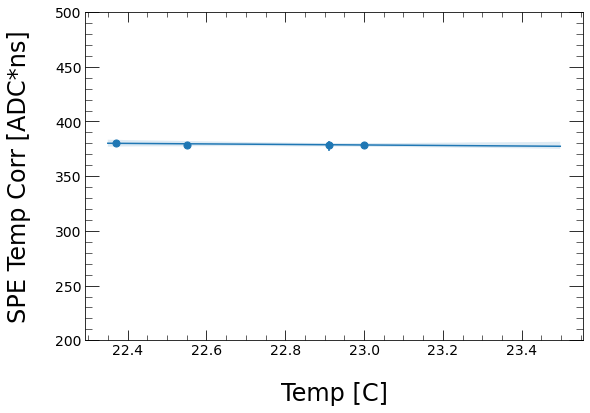

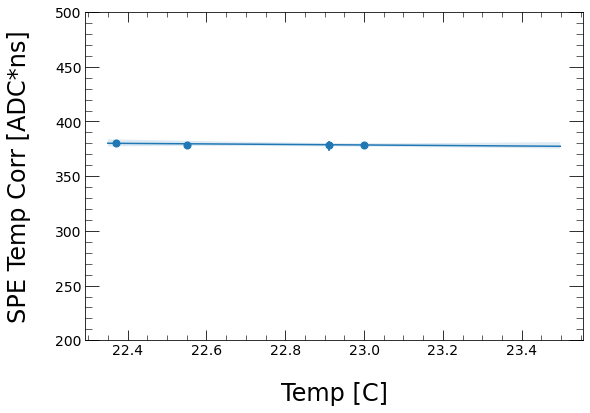

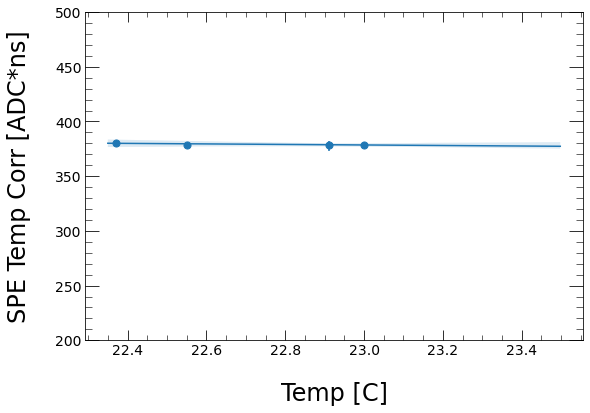

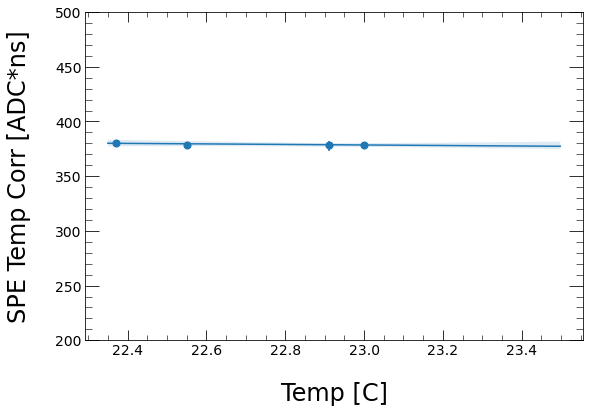

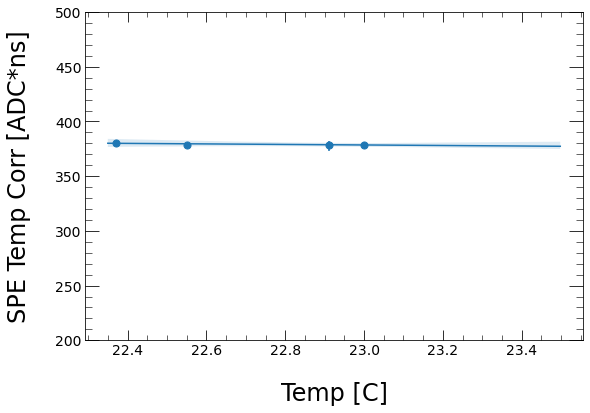

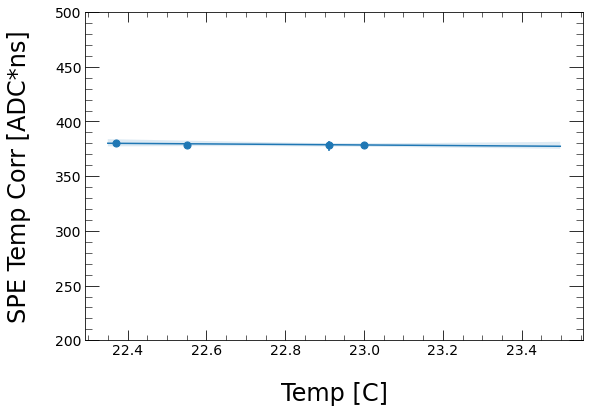

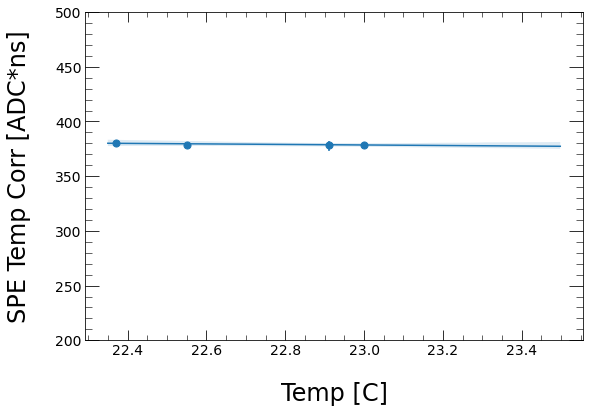

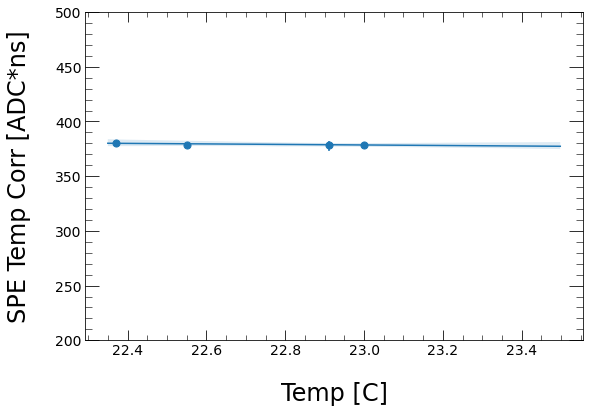

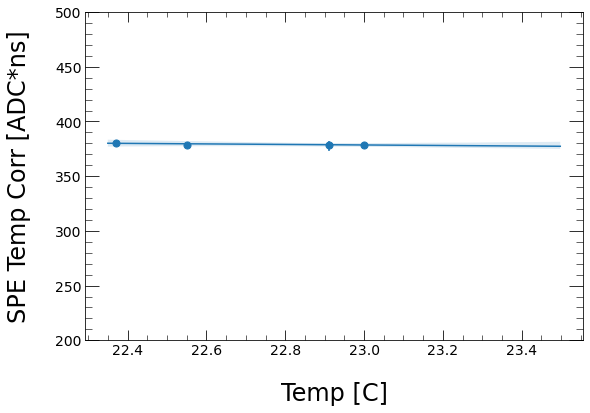

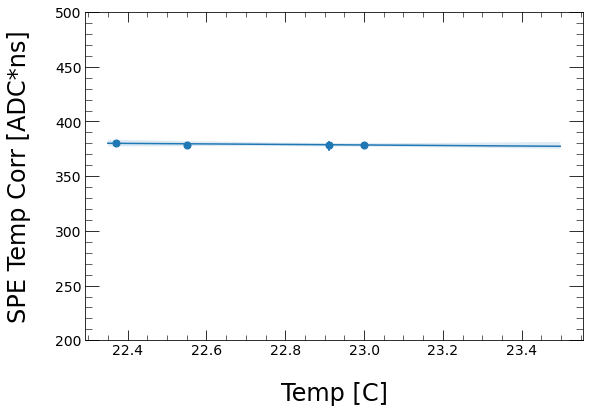

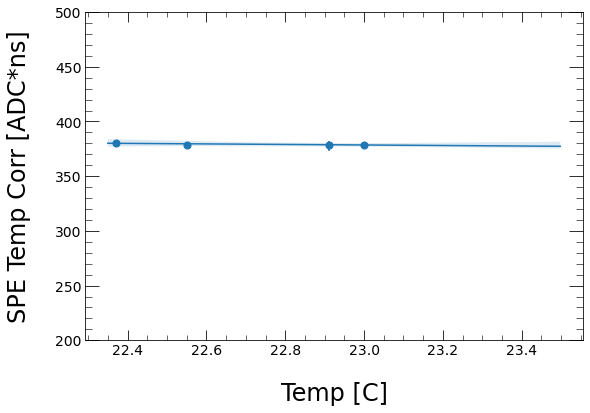

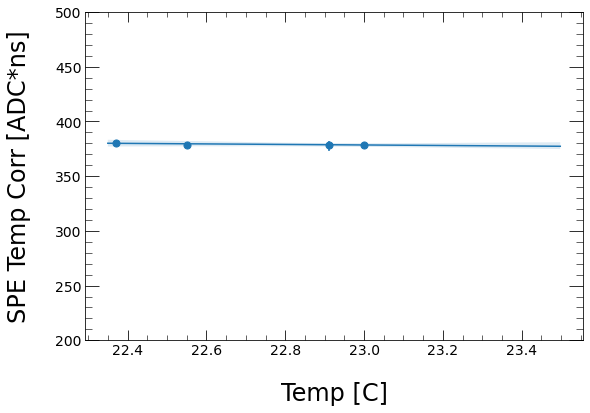

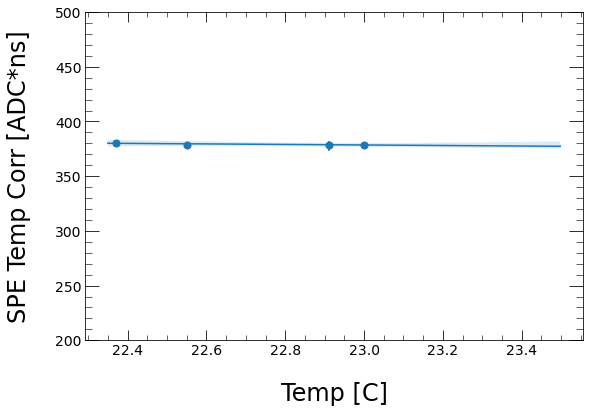

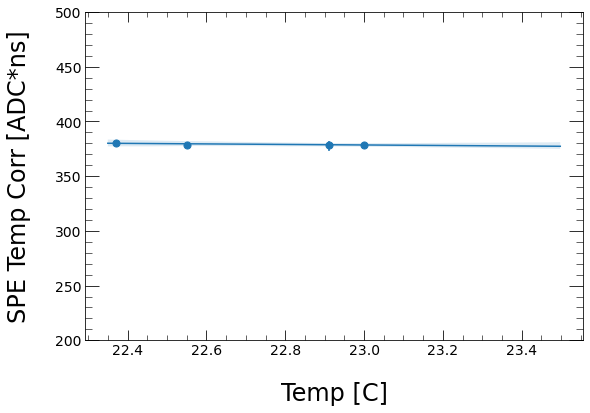

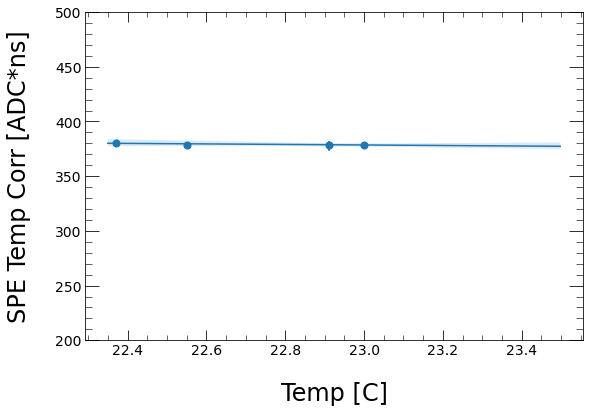

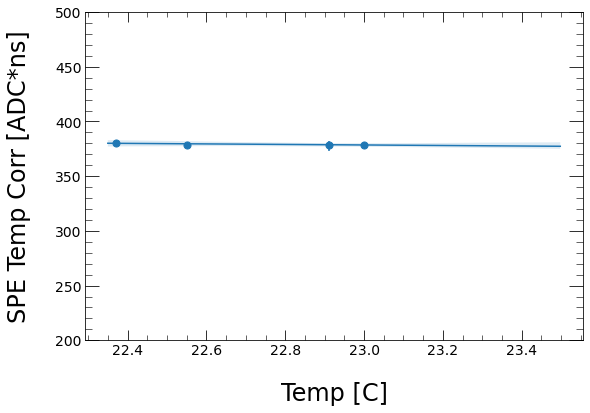

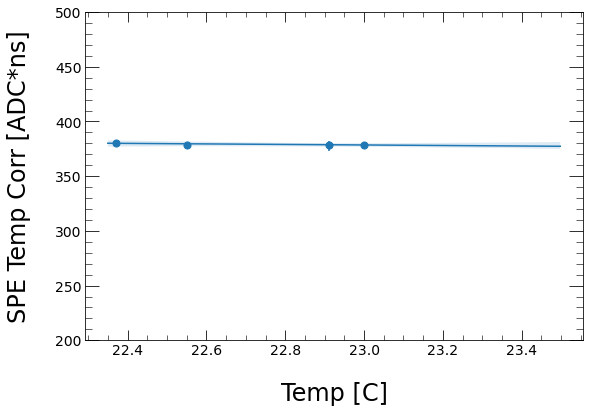

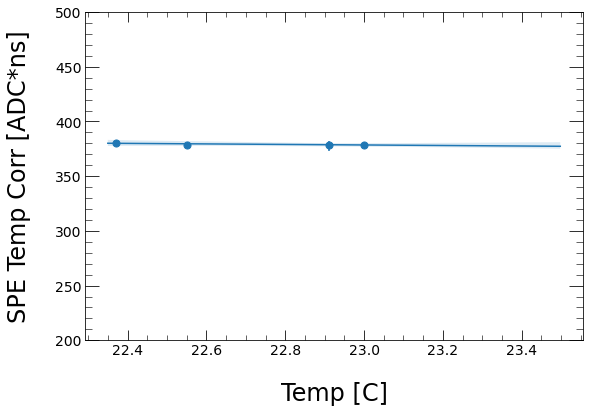

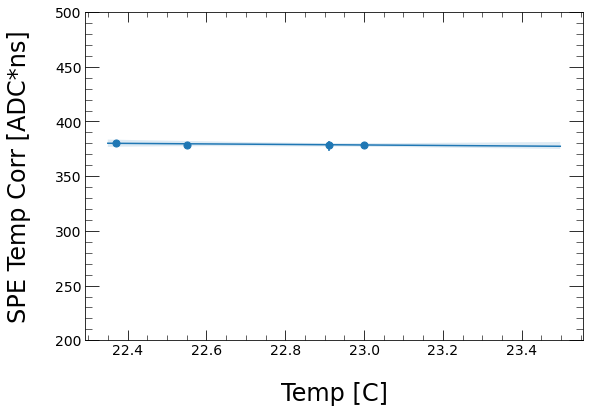

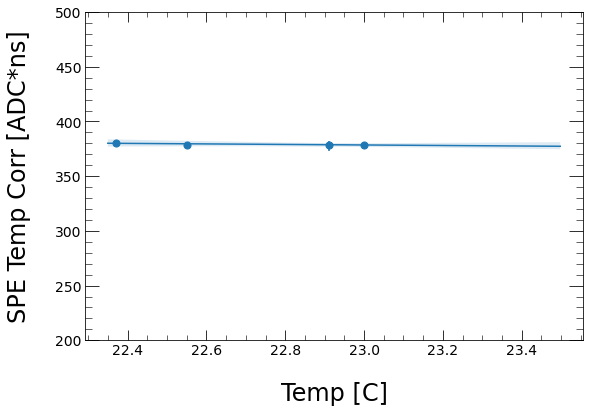

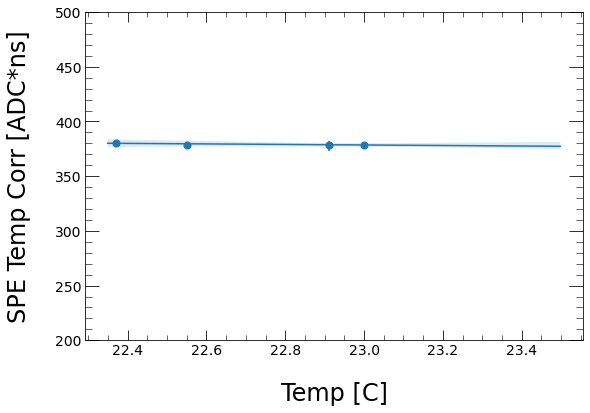

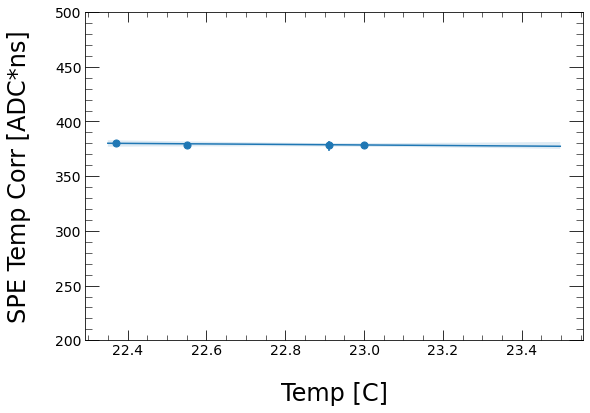

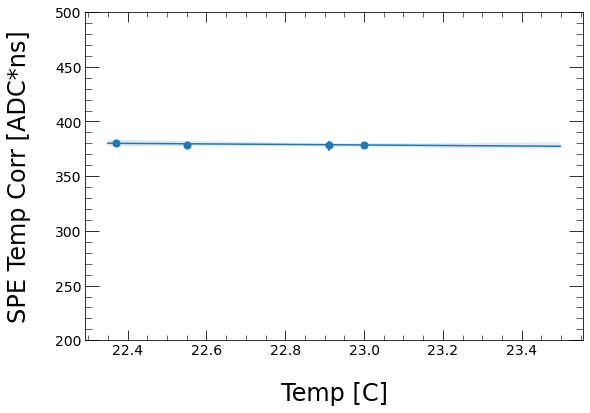

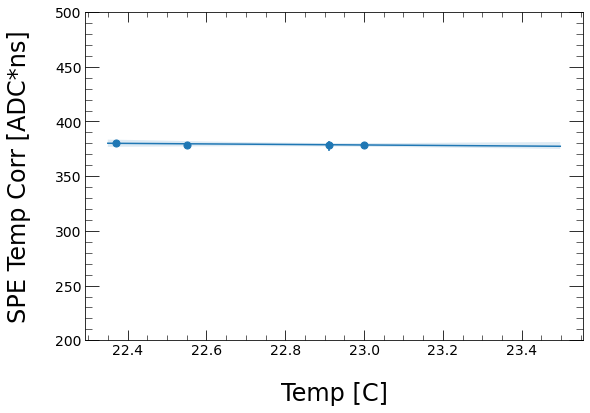

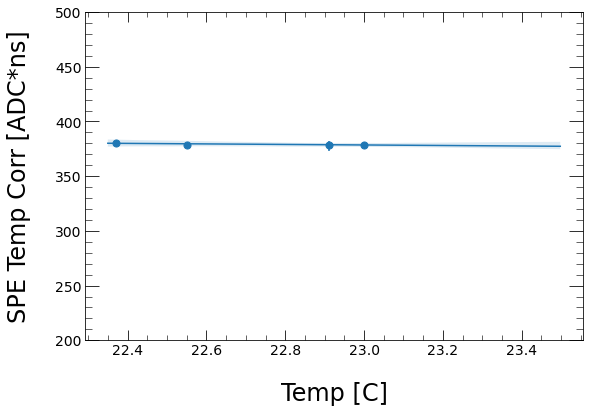

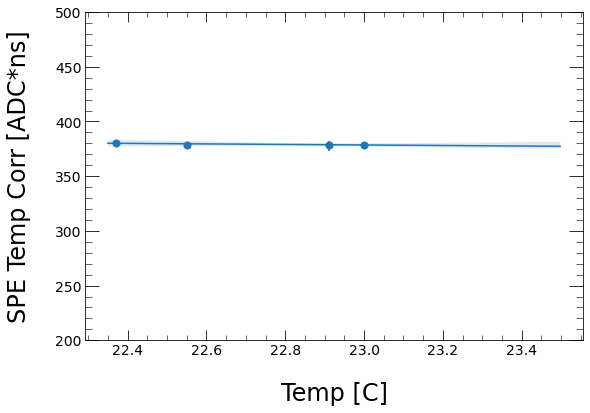

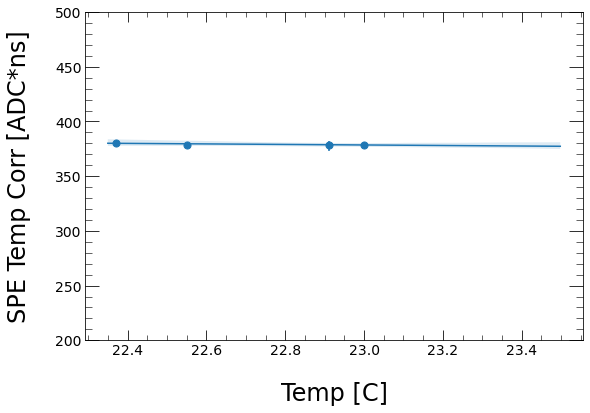

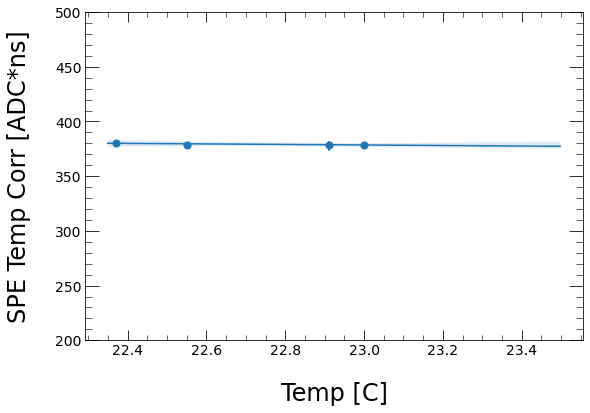

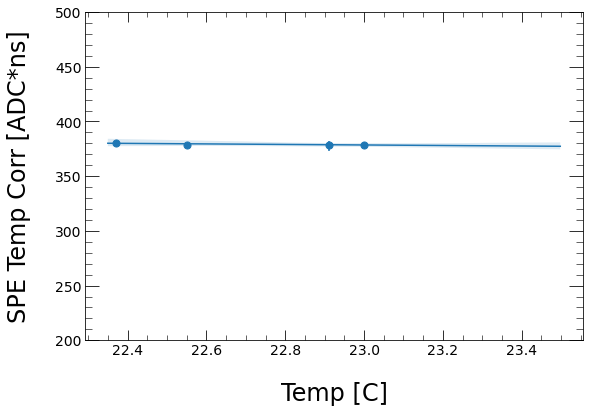

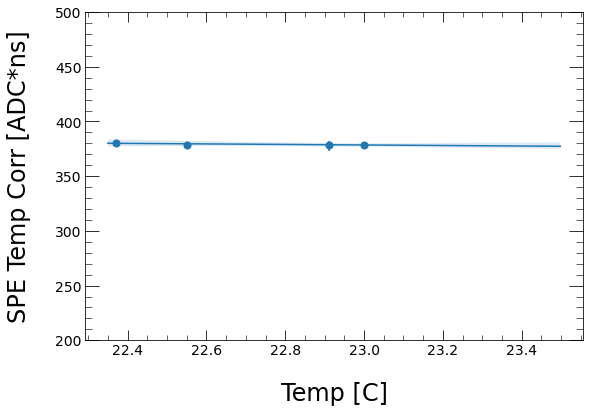

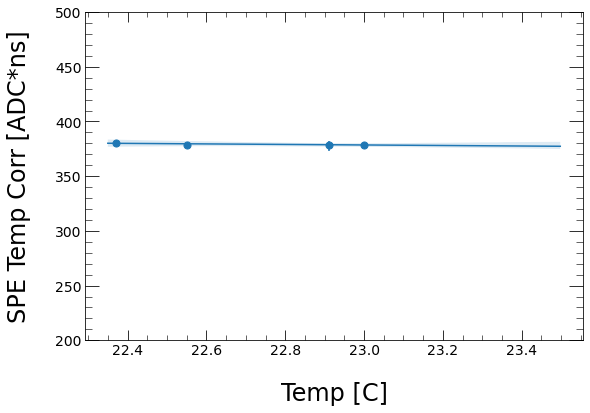

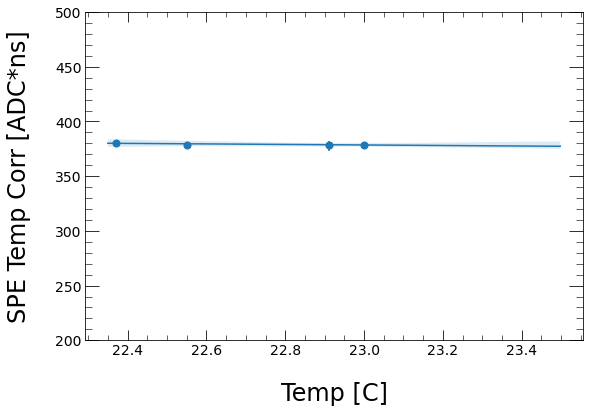

In [96]:
channel_range=range(0, 64)

for feb in range(0, 2):
  for chan in channel_range:
    plt.figure()    
    x=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['meanTemperatures_0_0']
    y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['calibConstantsTemperatureCorrected_%d_%d'%(feb, chan_infeb)]
    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=True)

    plt.ylabel('SPE Temp Corr [ADC*ns]')
    plt.xlabel('Temp [C]')
    plt.ylim(200, 500)